# Slope Analysis

This project use the change of fluorecent intensity slope to identify responders from calcium imaging experiment.

## Analysis Steps

The `getBaselineAndMaxStimulationSlopeFromCSV` function smoothes the raw data by the moving window decided by `filterSize`, and analyzes the smoothed Ca intensity in an CSV and returns baseline slope and drug slope.

The _slope of baseline_ is calculated as the linear regression slope during the 3 minutes period before stimulation onset.

In addition, the smoothed data are separated into segments which n = regressionSize data points are included. The linear regression slope is then calculated for each segment. 

The _peak slope of stimulation_ is the most negative slope during the chosen stimulation period.

## Set-Up the Environment

In [176]:
%load_ext autoreload
import sys
sys.path.append("../src")
import os
import glob
import slopeTools
import plotTools
import statsTools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pandas DataFrame as a Database

This script creates a single dataframe containing AFU data for every structure in all experiments. 

Columns define group, drug, distance, structure, etc.

This large dataframe can be queried as needed, or exported as a CSV.

In [177]:
database = pd.DataFrame(columns = ['Group', 'Distance', 'MCN','Sniffer','AFU'])

def addGroup(folderPath, groupName):    
    filePaths = glob.glob(folderPath+"/*.xls")
    filePaths = [x for x in filePaths if x.endswith("um.xls")]
    for filePath in filePaths:
        fileName = os.path.basename(filePath)
        #distance = int(fileName.replace("um.xls", ""))
        addExperiment(filePath, groupName)
        
def addExperiment(filePath, groupName):    
    global database   #global reads a variable outside the function
    df = pd.read_csv(filePath, delimiter="\t")
    roiNames = df.columns[1:] #return to the column labels 
    for roiName in roiNames:
        mcn, distance, sniffer = roiName.split(".")
        distance = int(distance.replace("um", ""))
        afu = df[roiName].values
        row = {'Group': groupName, 'Distance': distance, 'MCN': mcn, 'Sniffer':sniffer, 'AFU':afu}
        database = database.append(row,ignore_index = True)
        
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 Cs-GLU analyze", "CsGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 K-GLU analyze", "KGlu")
addGroup(R"X:\Data\OT-Cre\OT-GCaMP-nonspecific\04-03-19 evoke OT\04-30-2020 L368 - Cs analyze", "L368")

database

Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
441   L368      125  20217028     C15   
442   L368      125  20217028     C16   
443   L368      125  20217028     C17   
444   L368      125  20217028     C18   
445   L368      125  20217028     C19   

                                                   AFU  
0    [1286.65983, 1266.2571699999999, 1189.49916999...  
1    [2948.64467, 2962.93833, 3239.71167, 3417.8625...  
2    [5736.4195, 5736.50717, 5026.41233, 4580.00867...  
3    [2283.93833, 2211.74517, 2253.62167, 2301.0938...  
4    [2045.98417, 1792.38467, 2021.4029999999998, 1...  
..                                                 ...  
441  [1024.454, 1141.7939999999999, 1079.1860000000...  
442  [1149.15, 1137.655, 1136.93, 1116.005, 1118.42...  
443  [3113.2129999999997, 2974.022, 3031.2940000000...  
444  [1648.366, 1611.486, 1646.211, 1597.274, 1576....  
445  [2047.76, 1929.9379999999999, 2023.295, 1969.2...  

[446 rows x 5 columns]

# Convert raw AFU into dF/F (%)

In [338]:
baselineStartIndex = 20
treatmentStartIndex = 30
experimentPeriod = 5/60 #min
dFoFs = []
analyzed = database.copy()

analyzed["BaselineAFUMeans"] = [np.mean(x[baselineStartIndex:treatmentStartIndex]) for x in analyzed["AFU"].values]
for i in range(len(analyzed["AFU"])):
    dFoF = (analyzed["AFU"][i]-analyzed["BaselineAFUMeans"][i])*100/analyzed["BaselineAFUMeans"][i]
    dFoFs.append(dFoF)
    
analyzed["Raw dF/F (%)"] = dFoFs

analyzed = analyzed.drop(columns=["AFU", "BaselineAFUMeans"], axis=1)


analyzed

Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
441   L368      125  20217028     C15   
442   L368      125  20217028     C16   
443   L368      125  20217028     C17   
444   L368      125  20217028     C18   
445   L368      125  20217028     C19   

                                          Raw dF/F (%)  
0    [26.876577163943114, 24.864685904510754, 17.29...  
1    [-1.6574346372227533, -1.1807155509507214, 8.0...  
2    [28.56409879575307, 28.56606364761605, 12.6514...  
3    [27.972329497133295, 23.927243542925748, 26.27...  
4    [23.747368607671493, 8.408896655945105, 22.260...  
..                                                 ...  
441  [-0.5552749665760618, 10.83503053803611, 4.757...  
442  [11.070408867461687, 9.959366488371503, 9.8892...  
443  [37.94349143568214, 31.77607130849393, 34.3137...  
444  [12.440712290178862, 9.925000688955723, 12.293...  
445  [11.959930268344399, 5.5180899628023, 10.62232...  

[446 rows x 5 columns]

# Smooth raw data by filtersize

In [339]:
filterSize = 5
regressionSize = 10

length = [len(x) for x in analyzed["Raw dF/F (%)"].values]
maxLength = max(length)
time = np.arange(maxLength)*experimentPeriod 
smoothTimes = statsTools.smoothY(time, filterSize)
analyzed["dF/F (%)"] = [statsTools.smoothY(x, filterSize) for x in analyzed["Raw dF/F (%)"].values]
analyzed


Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
441   L368      125  20217028     C15   
442   L368      125  20217028     C16   
443   L368      125  20217028     C17   
444   L368      125  20217028     C18   
445   L368      125  20217028     C19   

                                          Raw dF/F (%)  \
0    [26.876577163943114, 24.864685904510754, 17.29...   
1    [-1.6574346372227533, -1.1807155509507214, 8.0...   
2    [28.56409879575307, 28.56606364761605, 12.6514...   
3    [27.972329497133295, 23.927243542925748, 26.27...   
4    [23.747368607671493, 8.408896655945105, 22.260...   
..                                                 ...   
441  [-0.5552749665760618, 10.83503053803611, 4.757...   
442  [11.070408867461687, 9.959366488371503, 9.8892...   
443  [37.94349143568214, 31.77607130849393, 34.3137...   
444  [12.440712290178862, 9.925000688955723, 12.293...   
445  [11.959930268344399, 5.5180899628023, 10.62232...   

                                              dF/F (%)  
0    [21.84072307926667, 19.003907158001294, 16.241...  
1    [7.763973194601914, 9.775688043374481, 11.1001...  
2    [9.291335093843292, 10.769249062288777, 13.264...  
3    [28.11335145335973, 28.311119053030833, 28.082...  
4    [19.80381459331928, 18.16510188118031, 18.1830...  
..                                                 ...  
441  [10.466257991487444, 13.406909232091417, 14.97...  
442  [9.279000026418869, 8.943125970974036, 8.57640...  
443  [27.990417371697415, 25.14774112198889, 22.706...  
444  [10.585477304434109, 9.142399281266824, 8.3357...  
445  [9.000845538696714, 8.555905744715103, 8.89150...  

[446 rows x 6 columns]

# Delete sniffers that show severe exponential decay 

In [342]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

def calcRsquared(actual, expected):
    """Calculate rSquared discretely so we don't need sklearn."""
    squaredDiffs = np.power(actual - expected, 2)
    squaredDiffsFromMean = np.power(actual - np.mean(actual), 2)
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    return rSquared

def exponentialDecayFit(xs, ys):

    xs = np.array(xs)
    ys = np.array(ys)

    #plt.plot(xs, ys, '.')
    
    params, cv = curve_fit(monoExp, xs, ys,bounds=(-40, [2000, 30, 50]))
    m, t, b = params
    sampleRate = 20_000 # Hz
    tauSec = (1 / t) / sampleRate

    expCurveFitted = monoExp(xs, *params)
    expRsquared = calcRsquared(ys, expCurveFitted)
    #plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
    #print(expRsquared)
    return expRsquared

indexes =[]
for ysIndex in range(len(analyzed["dF/F (%)"])):
    ys = analyzed["dF/F (%)"].values[ysIndex]
    xs = smoothTimes[:len(ys)]
    rSquare = exponentialDecayFit(xs, ys)

    if rSquare > 0.90:
        indexes.append(ysIndex)
        analyzedCleaned = analyzed.drop(index=indexes, axis=1)


analyzedCleaned


Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
427   L368      125  19d09036      C1   
428   L368      125  19d09036      C2   
434   L368      125  19d09062      C8   
435   L368      125  19d09062      C9   
441   L368      125  20217028     C15   

                                          Raw dF/F (%)  \
0    [26.876577163943114, 24.864685904510754, 17.29...   
1    [-1.6574346372227533, -1.1807155509507214, 8.0...   
2    [28.56409879575307, 28.56606364761605, 12.6514...   
3    [27.972329497133295, 23.927243542925748, 26.27...   
4    [23.747368607671493, 8.408896655945105, 22.260...   
..                                                 ...   
427  [-0.4086253989051729, -1.5728694273641552, -0....   
428  [0.17781036529276772, 4.047615664363747, 0.864...   
434  [-21.72967814699643, 17.263367591447377, 13.91...   
435  [-0.020436071814665634, 1.7243421436191606, 0....   
441  [-0.5552749665760618, 10.83503053803611, 4.757...   

                                              dF/F (%)  
0    [21.84072307926667, 19.003907158001294, 16.241...  
1    [7.763973194601914, 9.775688043374481, 11.1001...  
2    [9.291335093843292, 10.769249062288777, 13.264...  
3    [28.11335145335973, 28.311119053030833, 28.082...  
4    [19.80381459331928, 18.16510188118031, 18.1830...  
..                                                 ...  
427  [0.7621180937095895, 1.675357936989765, 3.1968...  
428  [1.997204168044209, 2.153043222349471, 2.18559...  
434  [-2.407289679887425, 10.512901252428042, 9.999...  
435  [3.5902843764287824, 4.63325365515546, 5.41332...  
441  [10.466257991487444, 13.406909232091417, 14.97...  

[209 rows x 6 columns]

# Calculate the slope difference for each sniffer cell

In [341]:
baselineStartIndex = 15  # index is right shifted for 2.5 indexes after smoothing
treatmentStartIndex = 30  

def slopeDifferenceWithDataFrame(time, dataframe, dataColume,baselineStartIndex, treatmentStartIndex, treatmentDuration = 2.5):
    """
    This function uses the datacolume from a dataframe, calculates the baseline slope and the maximal treatment slope, 
    and generates a new column called "slope difference (%)" to show the change of slopes.
    """
    baselineSlopes =[]
    stimulationSlopes =[]
    baselineDFoFs = [x[baselineStartIndex:treatmentStartIndex] for x in dataframe[dataColume].values]        
    baselineTime = time[baselineStartIndex:treatmentStartIndex]
    segSlopesList = []
    for baselineDFoF in baselineDFoFs:
        baselineSlope, baselineIntercept, r, p, stdErr = scipy.stats.linregress(baselineTime, baselineDFoF)
        baselineSlopes.append(baselineSlope)
        baselineRegressionXs = np.linspace(time[baselineStartIndex], time[treatmentStartIndex])
        baselineRegressionYs = baselineRegressionXs * baselineSlope + baselineIntercept
    smoothedIntensities = [x for x in dataframe[dataColume].values]

    for smoothedIntensity in smoothedIntensities:
        segments = statsTools.getMovingWindowSegments(smoothedIntensity, regressionSize) 
        segSlopes = slopeTools.getAllSegmentSlopes(segments, experimentPeriod) 
        
        segSlopesList.append(segSlopes)

        segTimesOffset = (regressionSize * experimentPeriod)
        segTimes = statsTools.smoothY(smoothTimes, filterSize)
        treatmentStartTime = segTimes[treatmentStartIndex]
        treatmentEndTime = treatmentStartTime + treatmentDuration
        treatmentSlopeMax = statsTools.rangeMax(segSlopes, segTimes, treatmentStartTime, treatmentEndTime)
        treatmentSlopeMaxIndex = segSlopes.index(treatmentSlopeMax)
        treatmentSlopeMaxTime = segTimes[treatmentSlopeMaxIndex]
        stimulationSlopes.append(treatmentSlopeMax)

    dataframe["slopeDifference (%)"] = [stimulationSlopes[i] - baselineSlopes[i] for i in range(len(baselineSlopes))]
    return baselineRegressionXs, baselineRegressionYs, segTimes, segSlopes

baselineRegressionXs, baselineRegressionYs, segTimes, segSlopesList = slopeDifferenceWithDataFrame(smoothTimes, analyzedCleaned, 'dF/F (%)', baselineStartIndex, treatmentStartIndex)
 
analyzedCleaned

Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
427   L368      125  19d09036      C1   
428   L368      125  19d09036      C2   
434   L368      125  19d09062      C8   
435   L368      125  19d09062      C9   
441   L368      125  20217028     C15   

                                          Raw dF/F (%)  \
0    [26.876577163943114, 24.864685904510754, 17.29...   
1    [-1.6574346372227533, -1.1807155509507214, 8.0...   
2    [28.56409879575307, 28.56606364761605, 12.6514...   
3    [27.972329497133295, 23.927243542925748, 26.27...   
4    [23.747368607671493, 8.408896655945105, 22.260...   
..                                                 ...   
427  [-0.4086253989051729, -1.5728694273641552, -0....   
428  [0.17781036529276772, 4.047615664363747, 0.864...   
434  [-21.72967814699643, 17.263367591447377, 13.91...   
435  [-0.020436071814665634, 1.7243421436191606, 0....   
441  [-0.5552749665760618, 10.83503053803611, 4.757...   

                                              dF/F (%)  slopeDifference (%)  
0    [21.84072307926667, 19.003907158001294, 16.241...            11.784731  
1    [7.763973194601914, 9.775688043374481, 11.1001...             4.414812  
2    [9.291335093843292, 10.769249062288777, 13.264...            12.444155  
3    [28.11335145335973, 28.311119053030833, 28.082...             5.630190  
4    [19.80381459331928, 18.16510188118031, 18.1830...             5.667450  
..                                                 ...                  ...  
427  [0.7621180937095895, 1.675357936989765, 3.1968...             6.969439  
428  [1.997204168044209, 2.153043222349471, 2.18559...             1.386257  
434  [-2.407289679887425, 10.512901252428042, 9.999...            27.730756  
435  [3.5902843764287824, 4.63325365515546, 5.41332...             3.352028  
441  [10.466257991487444, 13.406909232091417, 14.97...            18.643010  

[209 rows x 7 columns]

In [289]:
type(segSlopesList)

list

# Plot the calcium signal and slops over time of individual cell

<ipython-input-350-9838a6ac62e8>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))


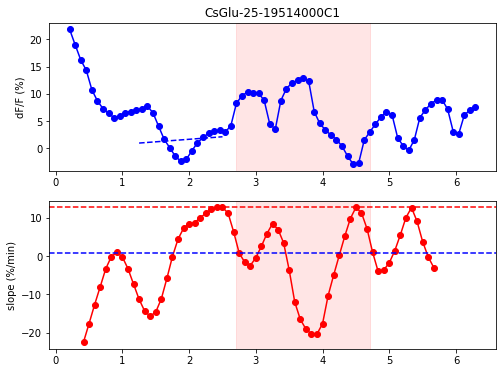

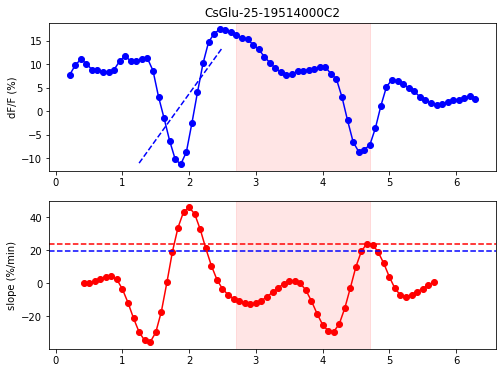

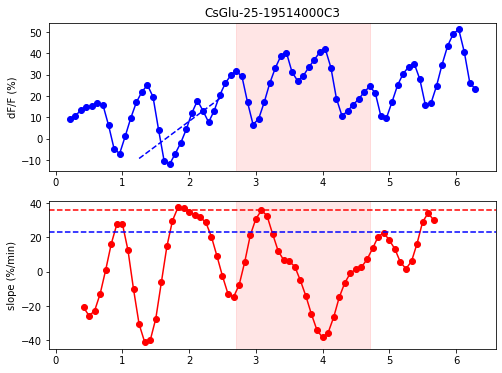

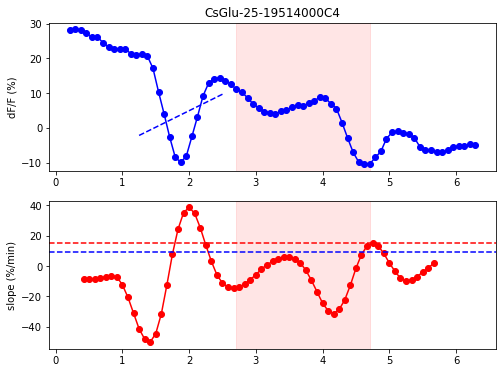

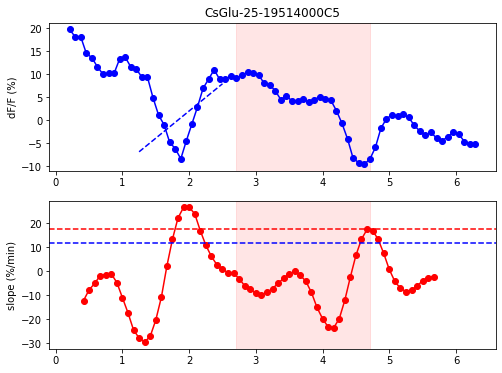

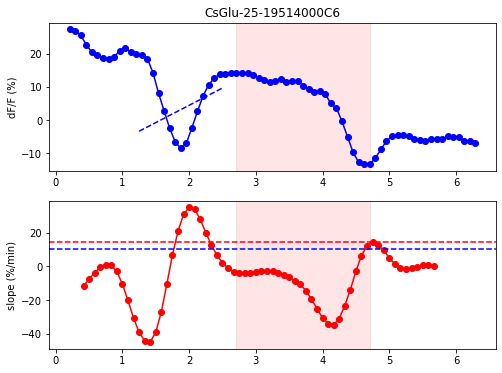

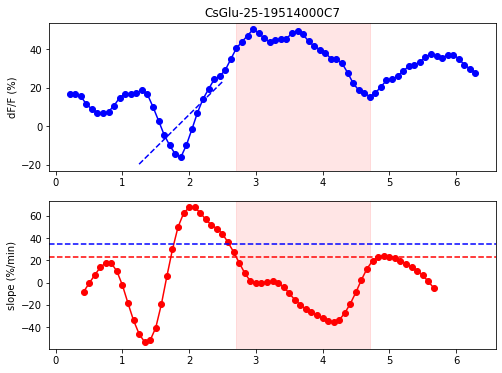

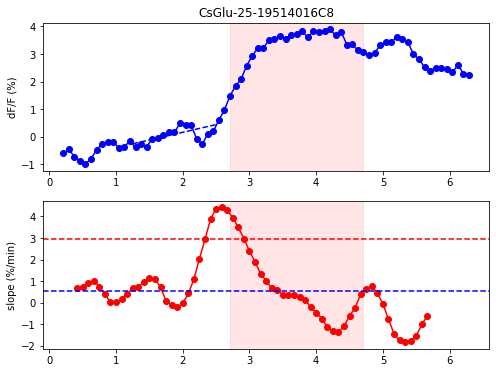

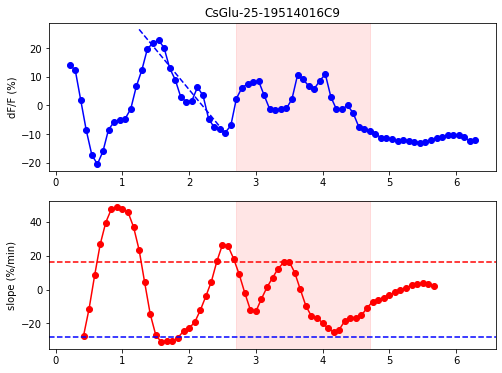

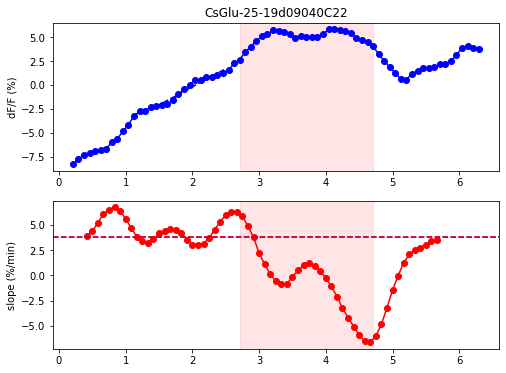

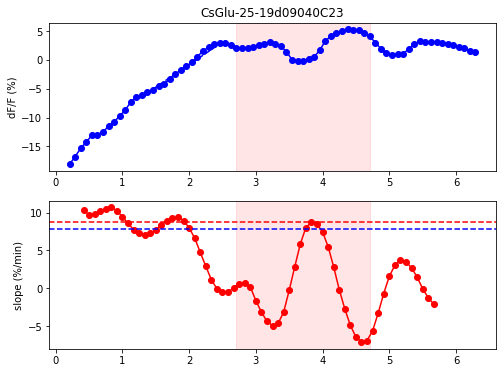

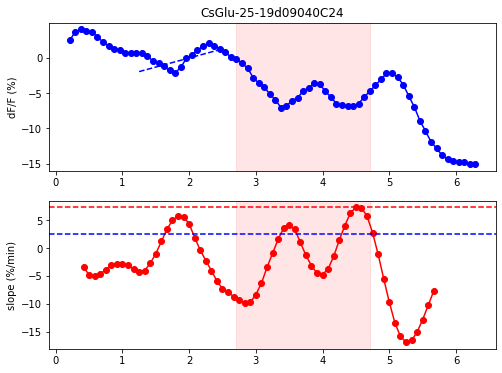

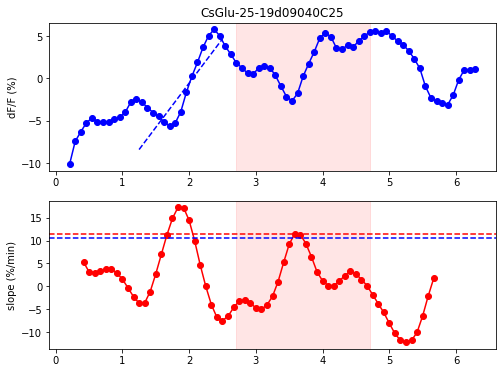

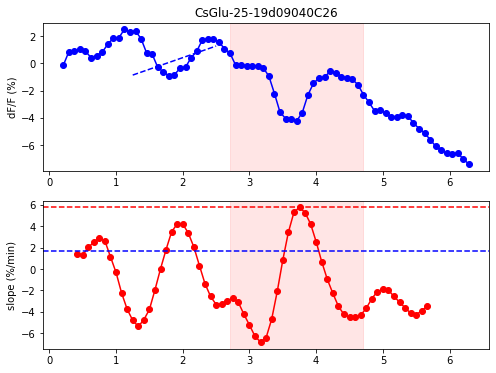

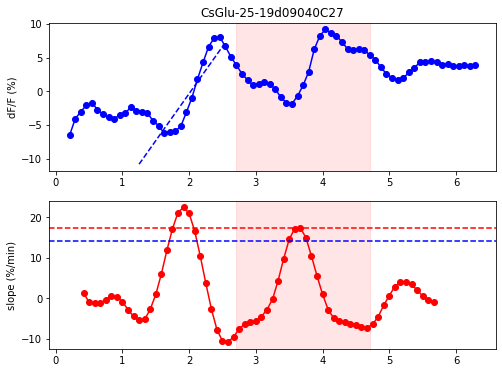

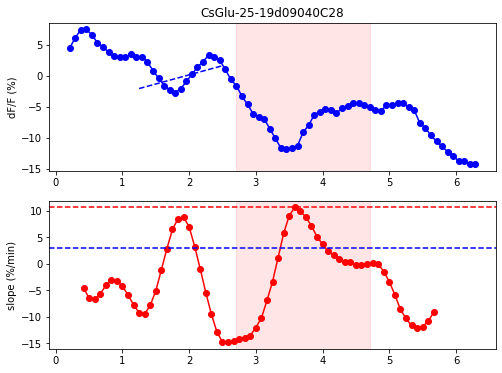

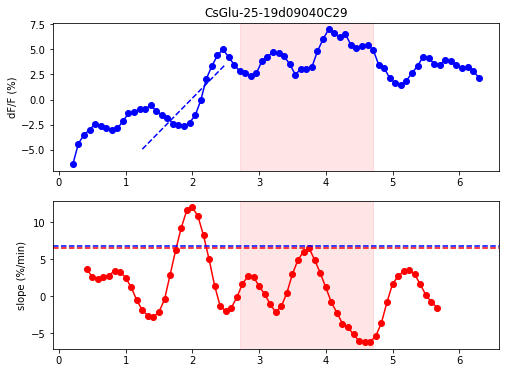

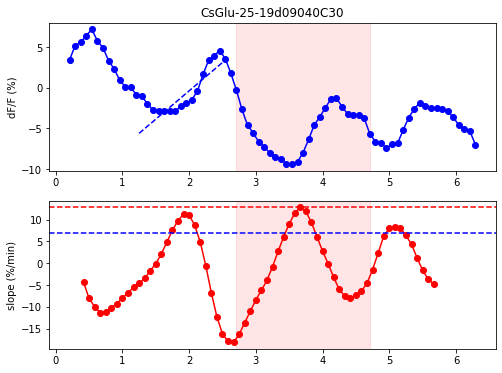

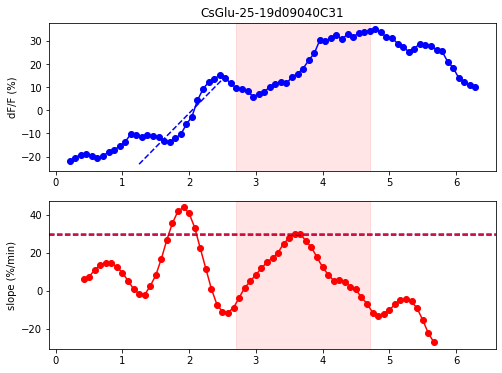

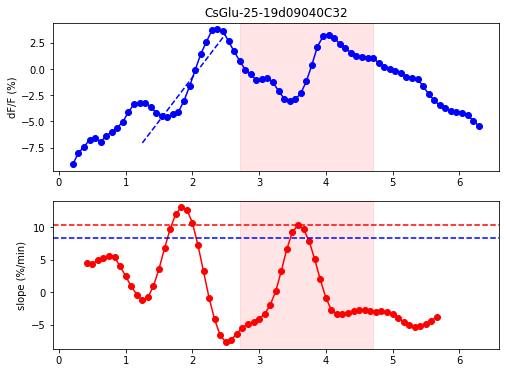

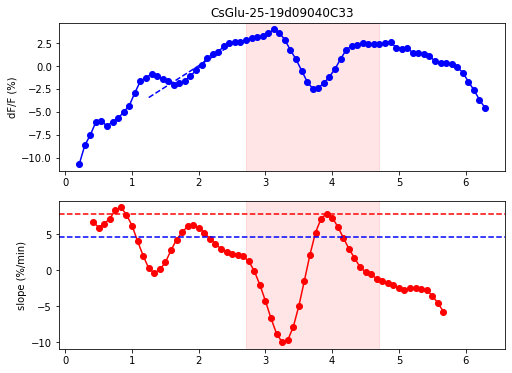

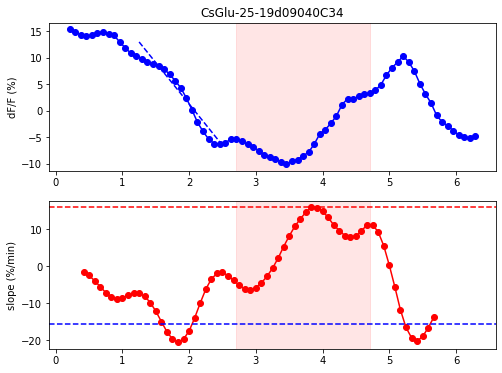

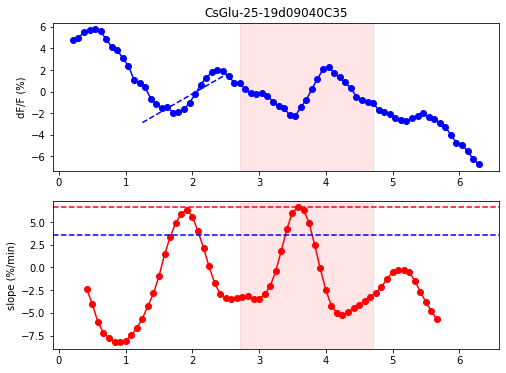

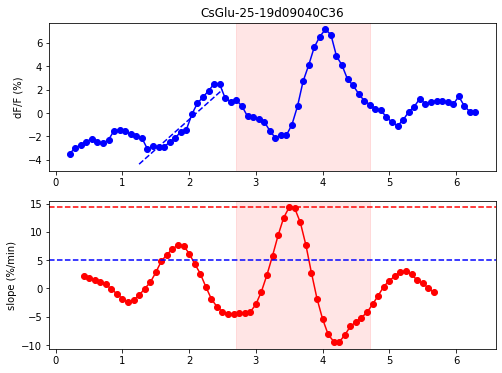

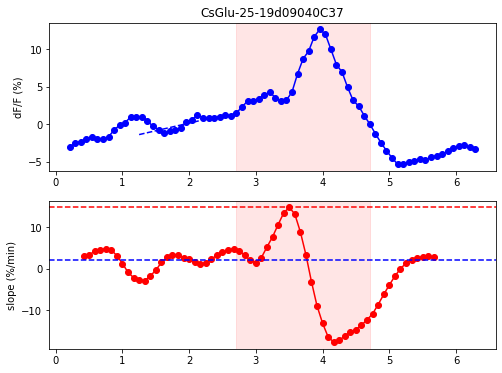

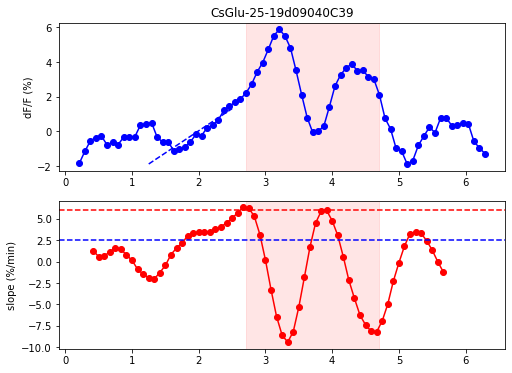

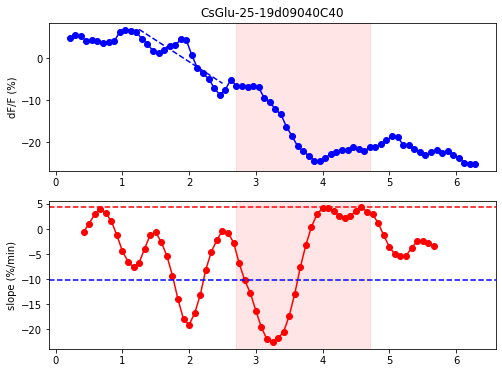

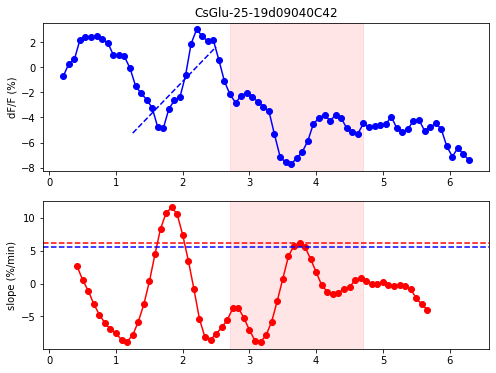

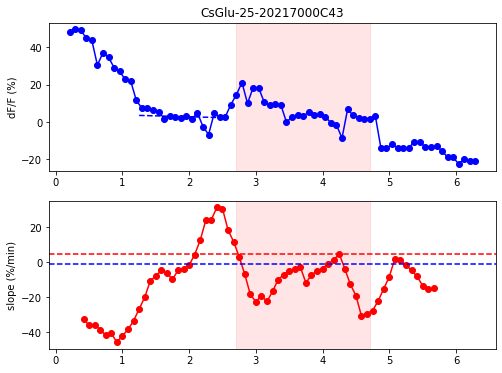

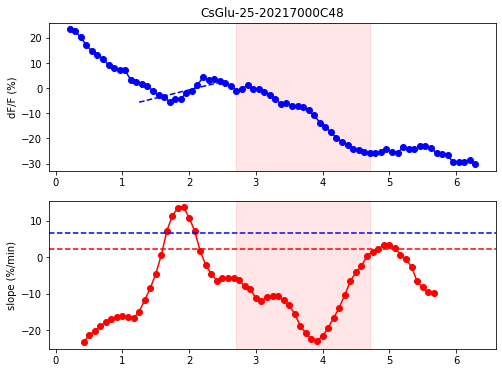

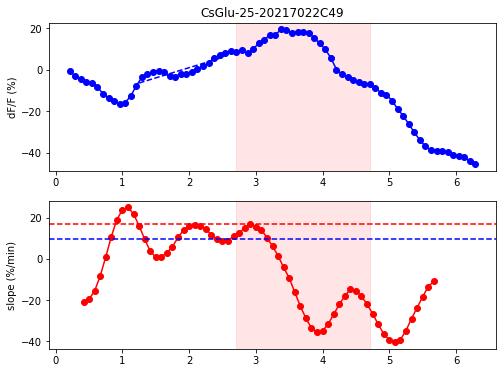

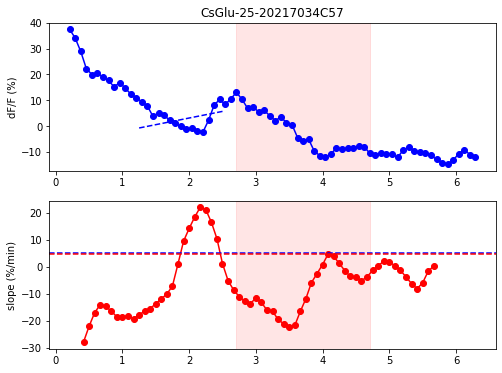

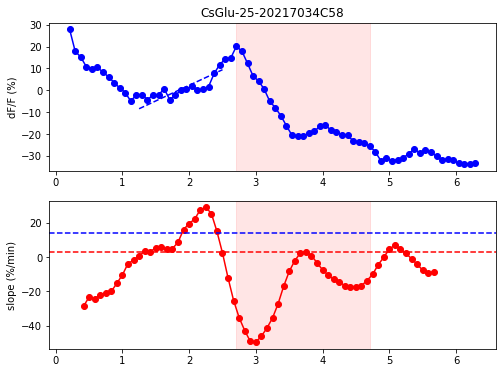

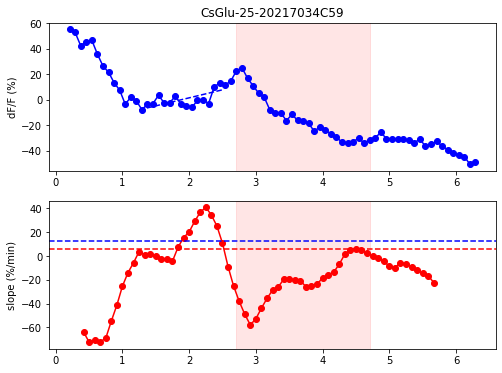

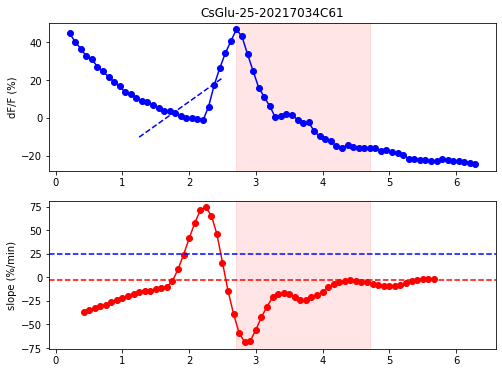

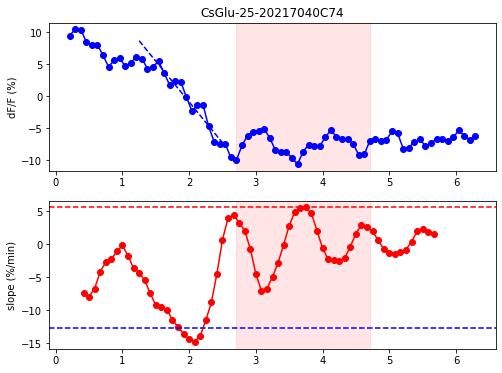

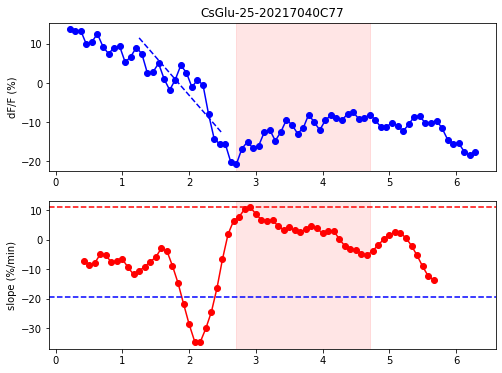

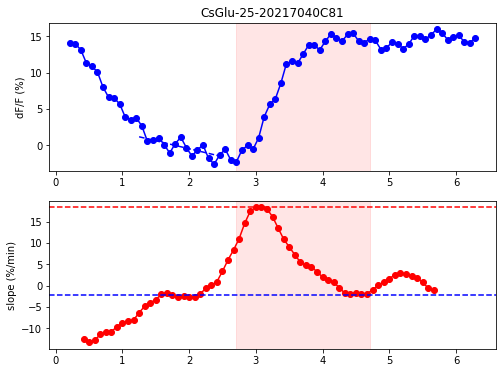

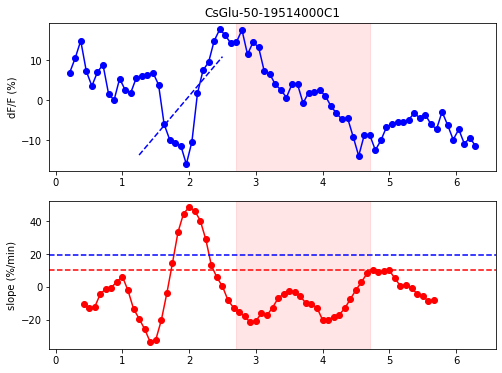

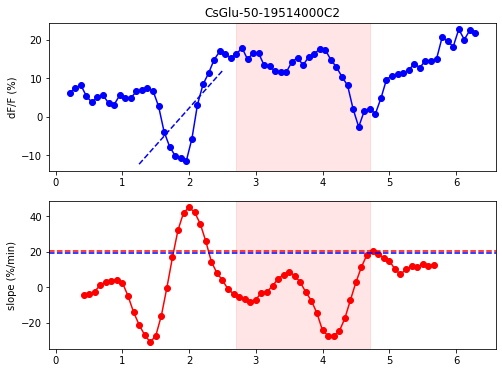

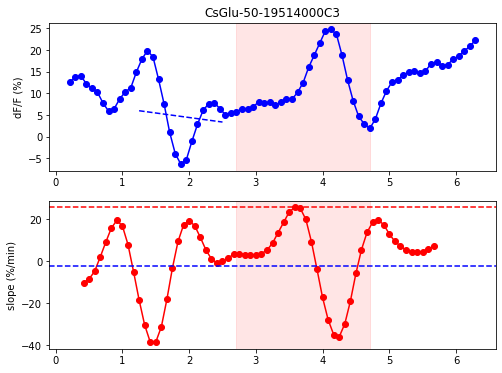

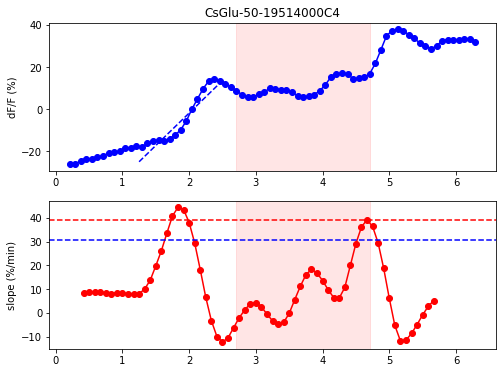

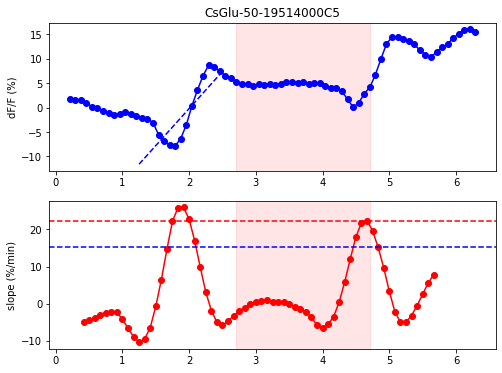

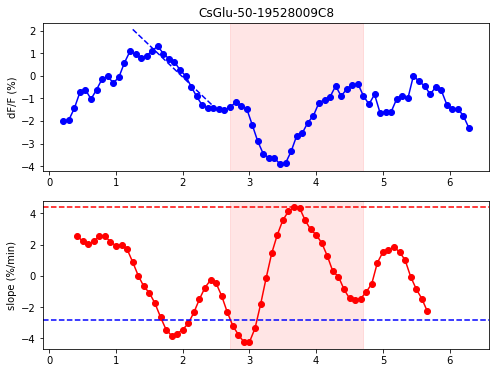

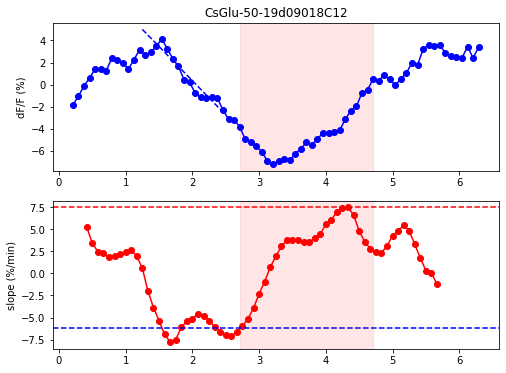

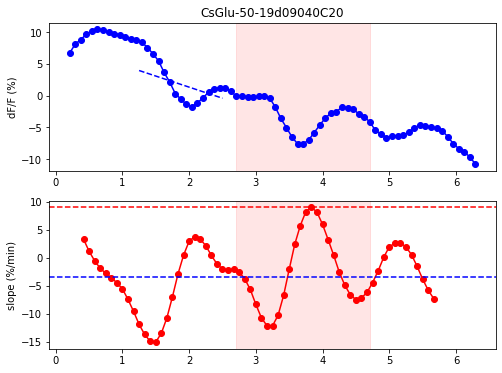

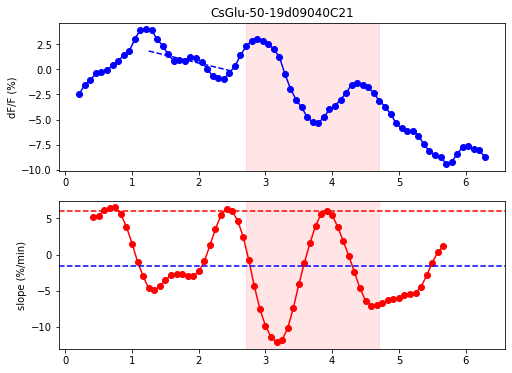

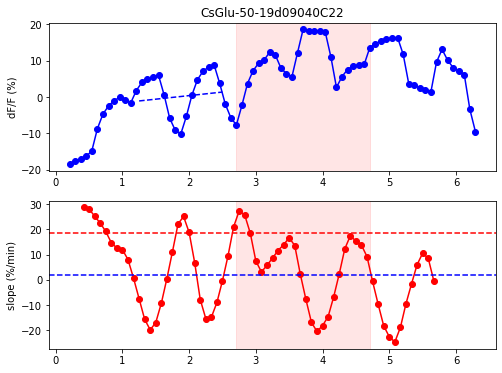

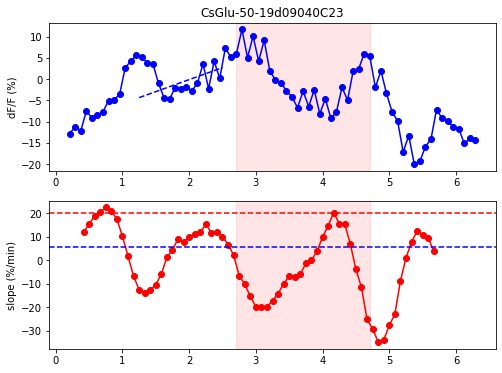

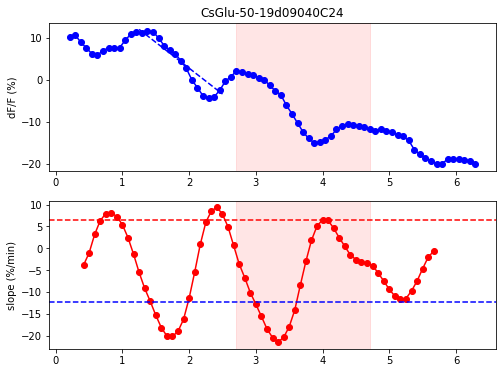

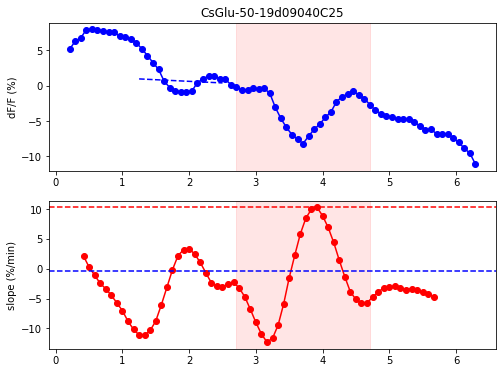

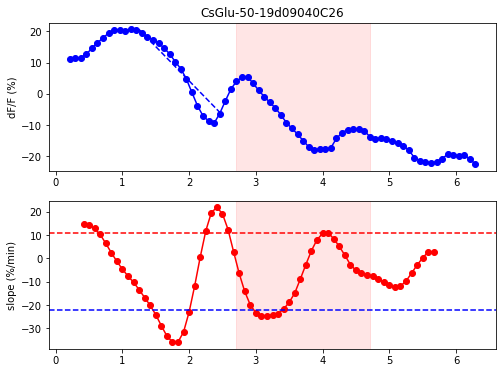

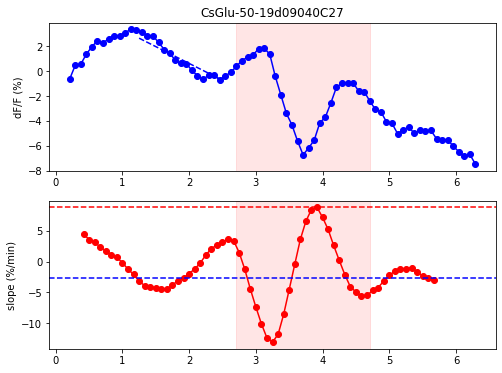

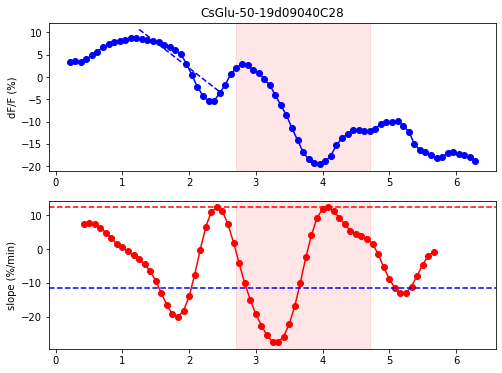

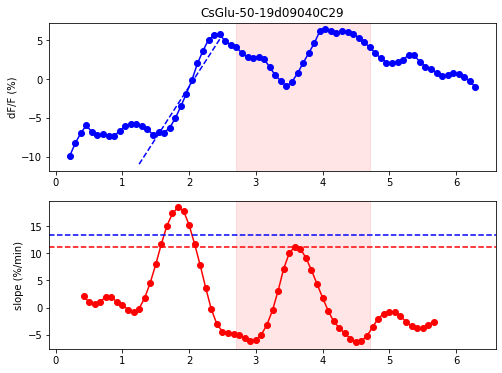

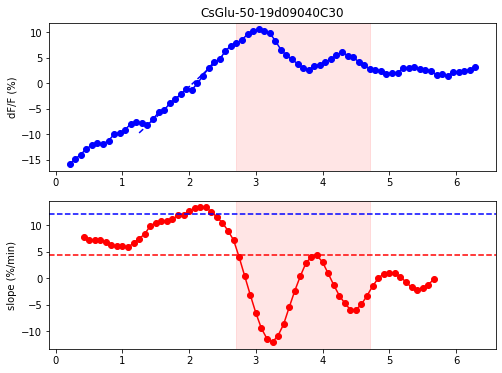

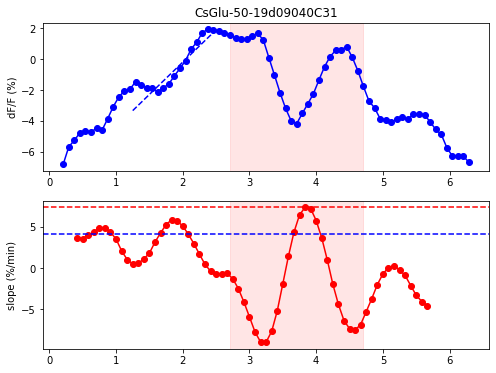

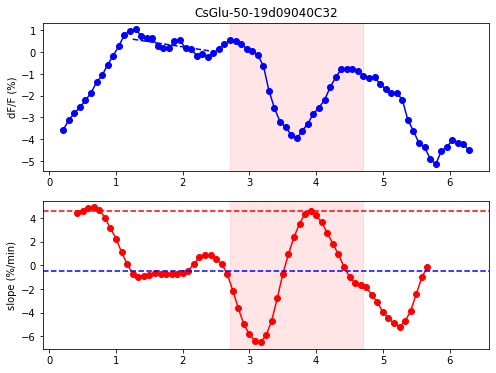

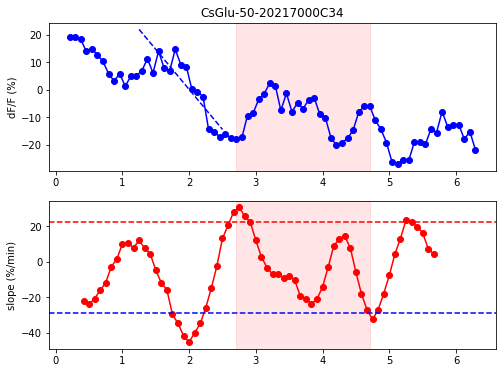

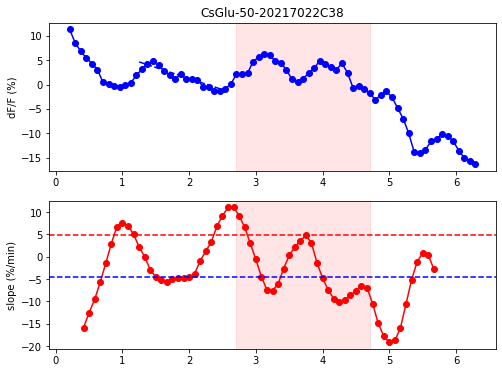

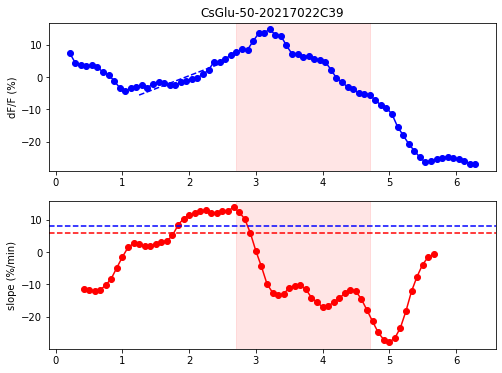

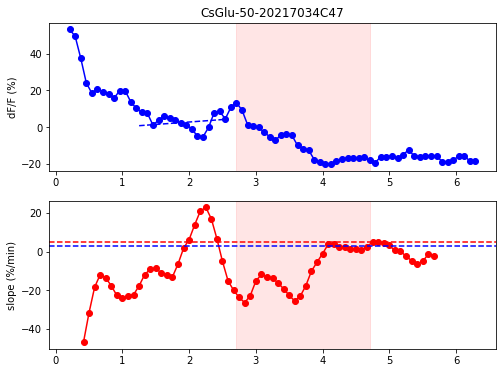

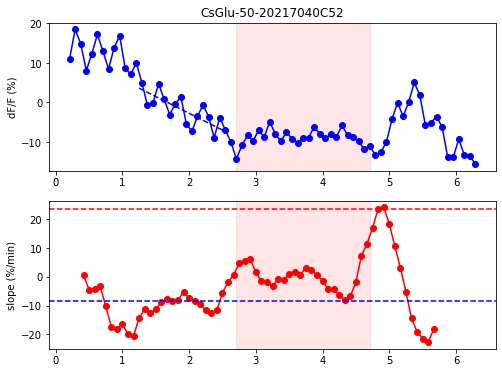

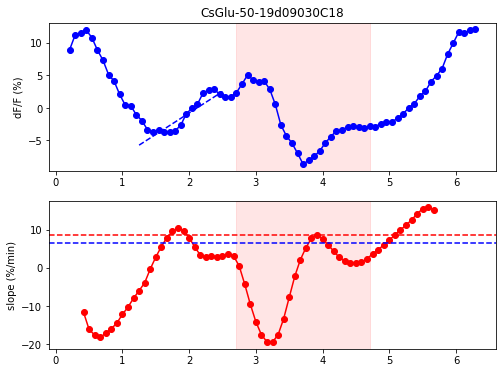

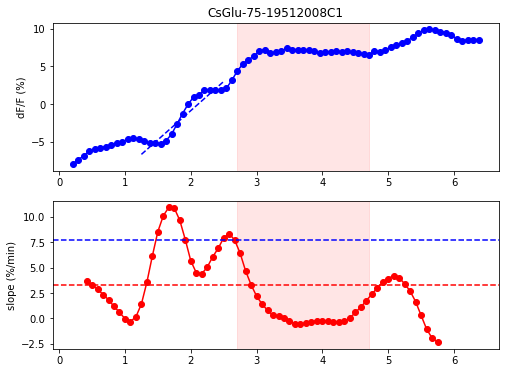

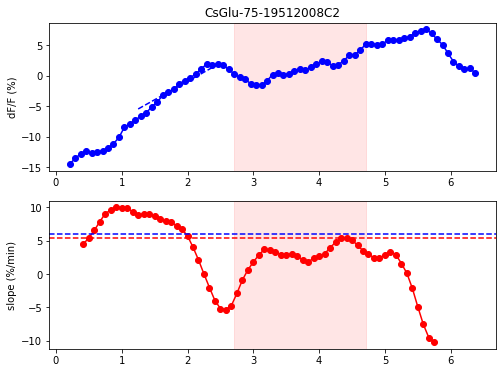

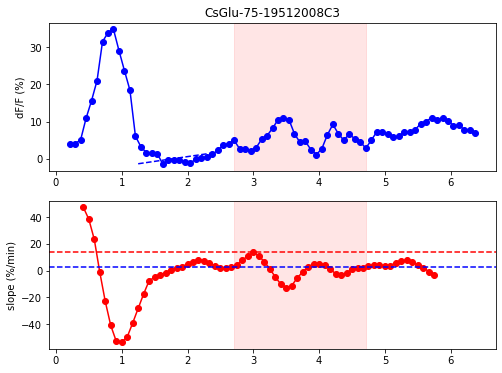

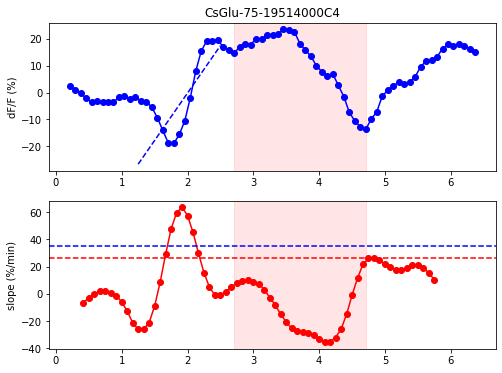

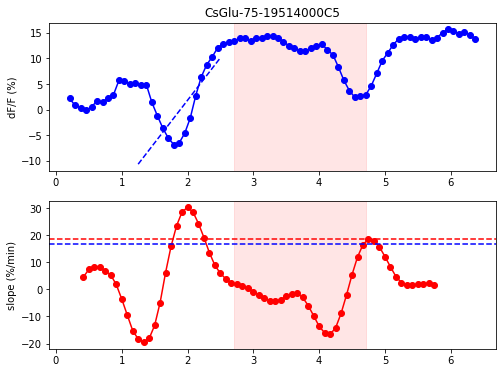

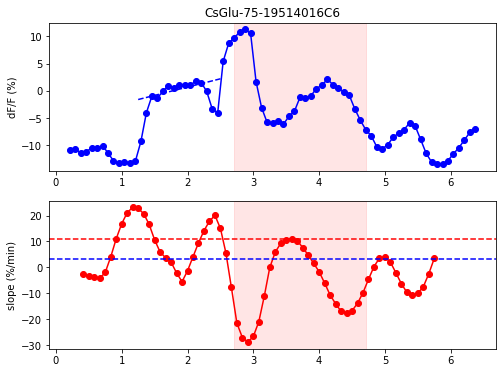

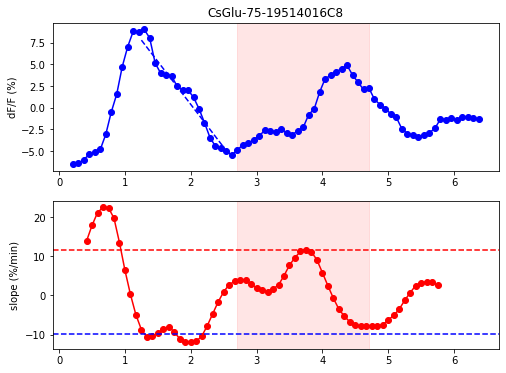

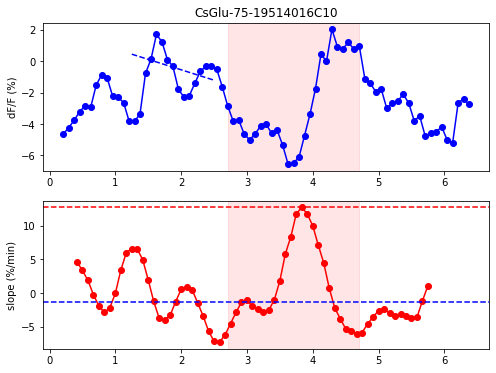

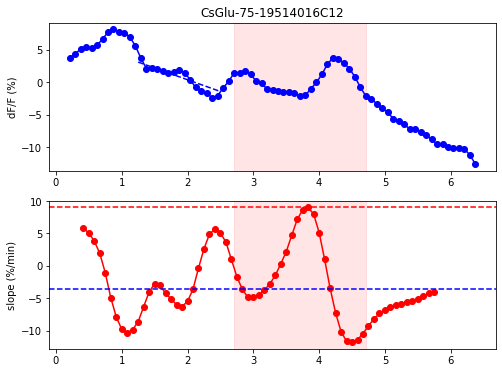

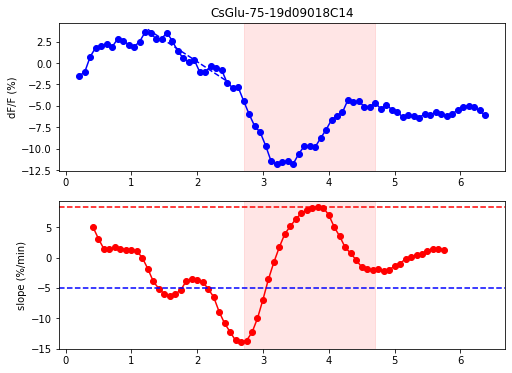

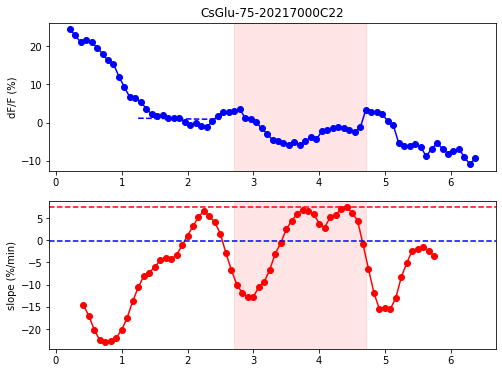

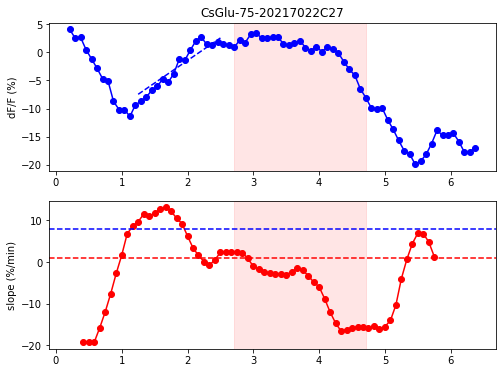

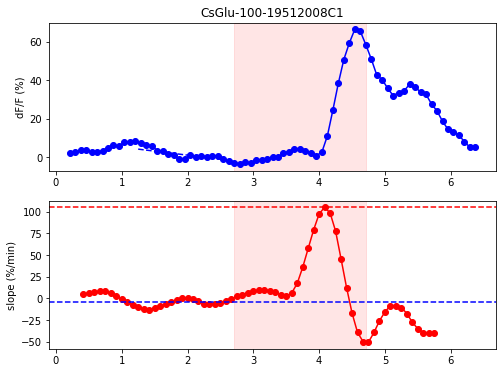

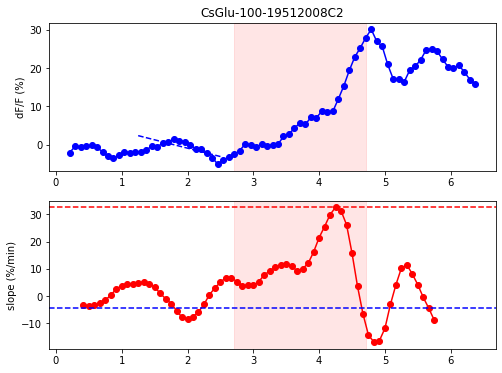

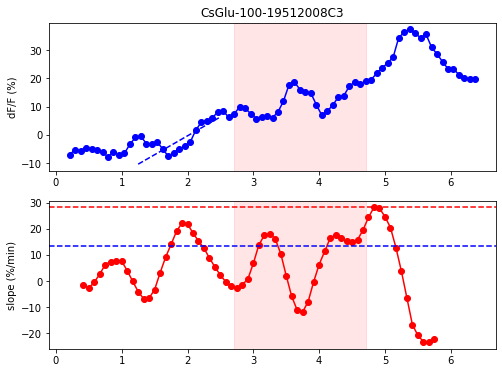

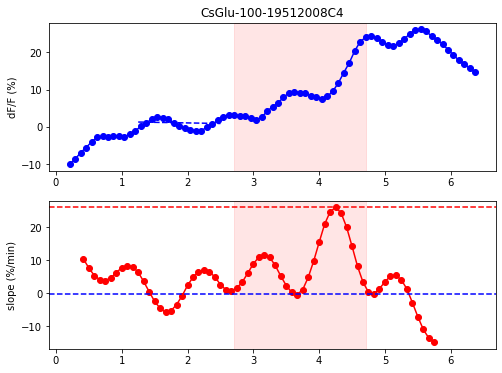

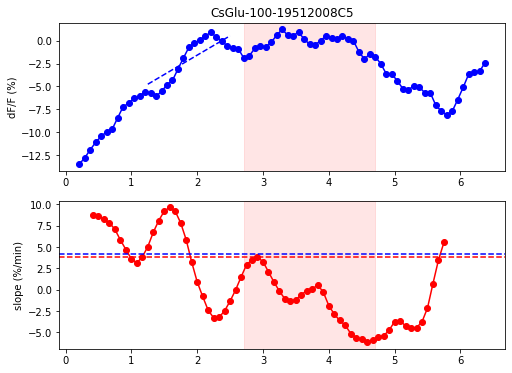

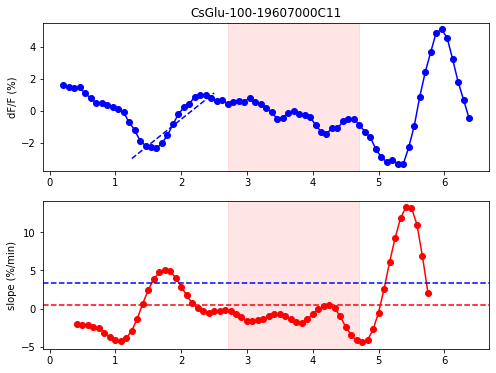

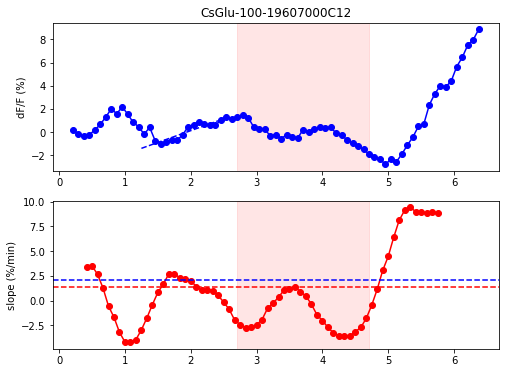

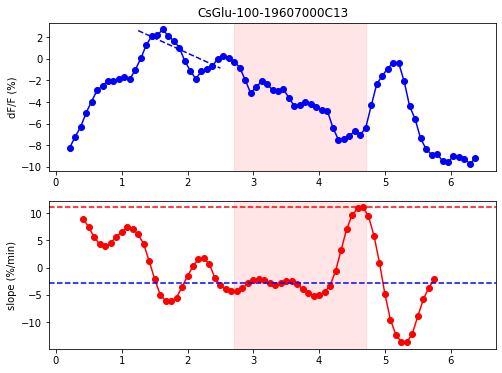

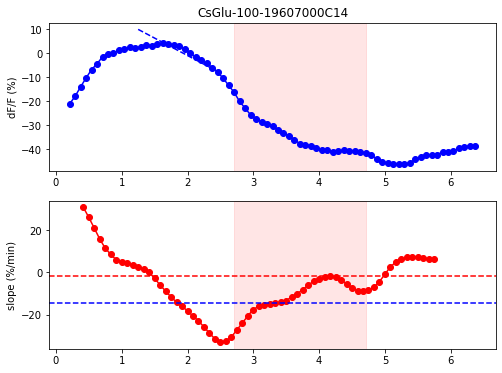

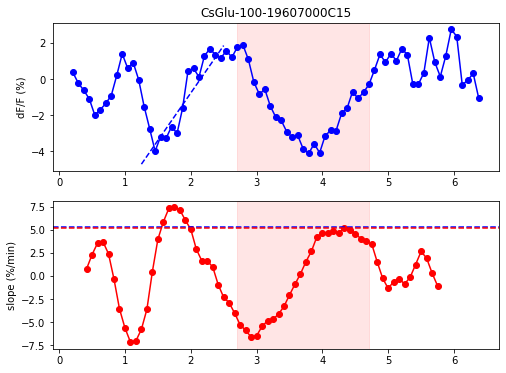

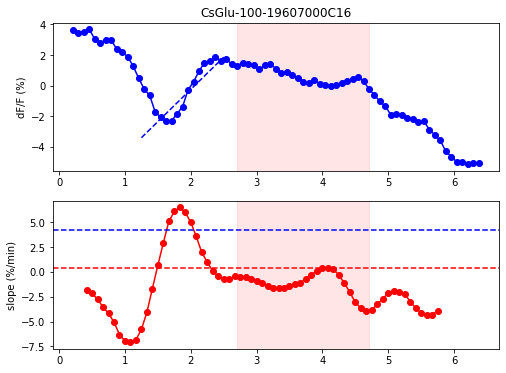

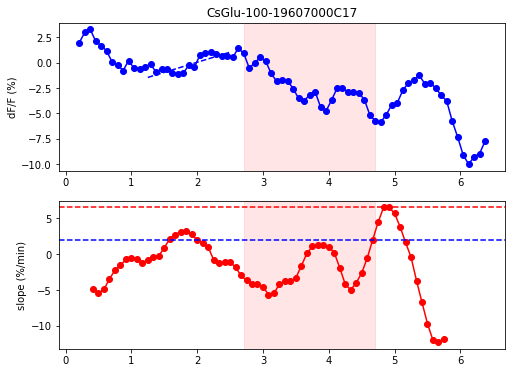

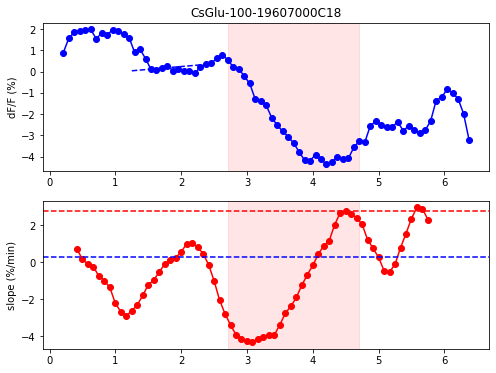

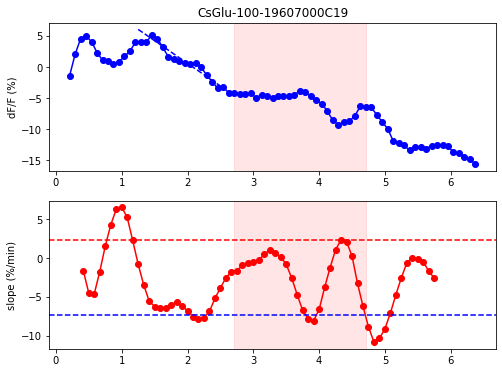

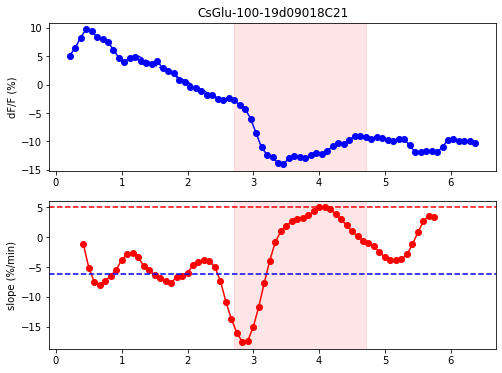

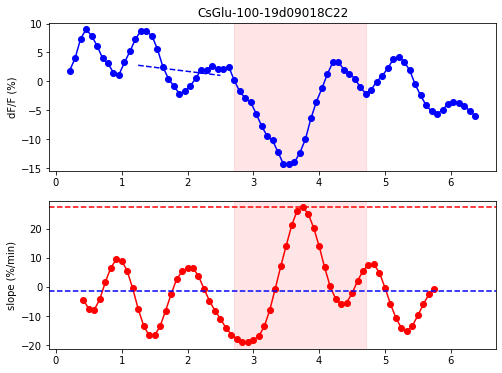

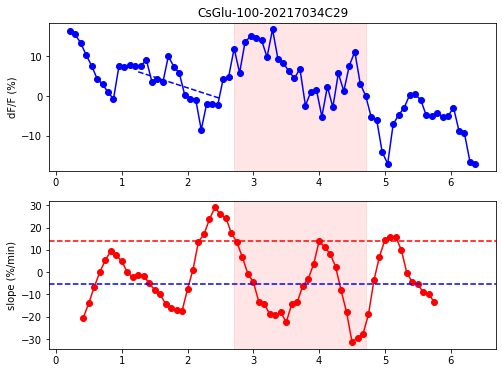

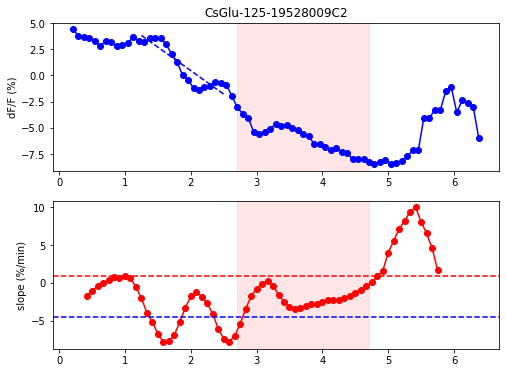

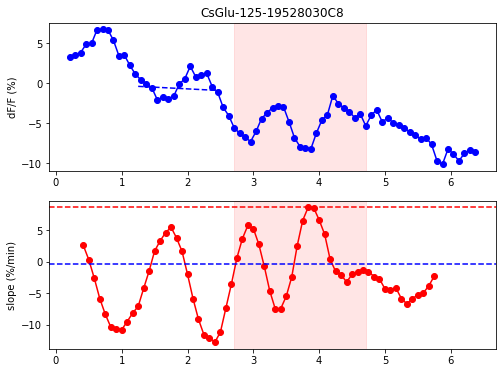

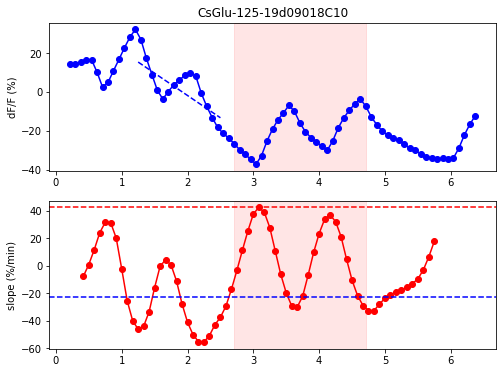

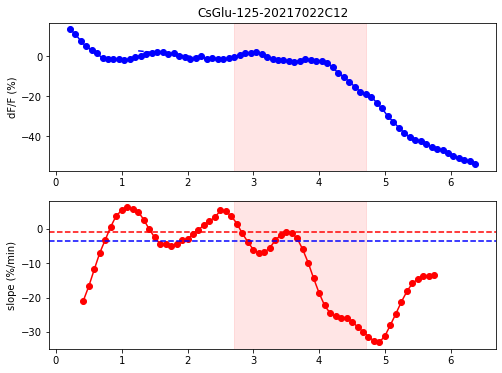

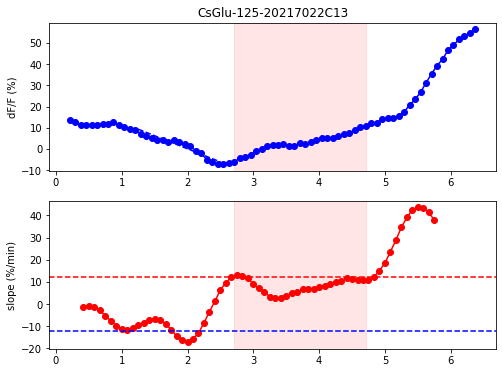

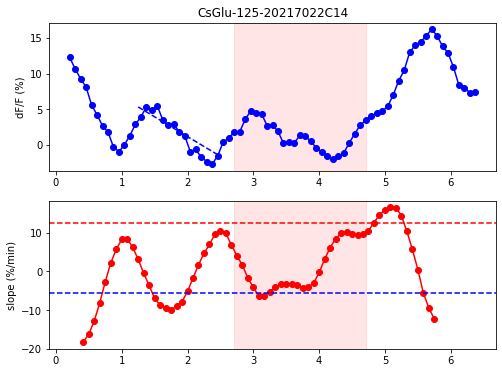

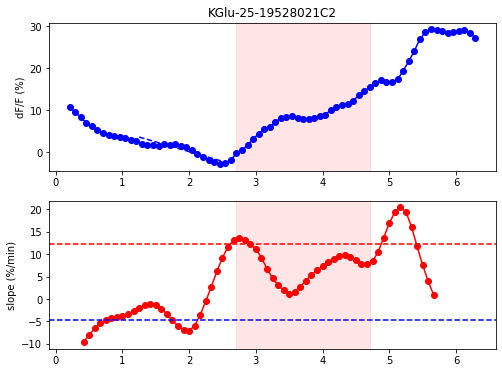

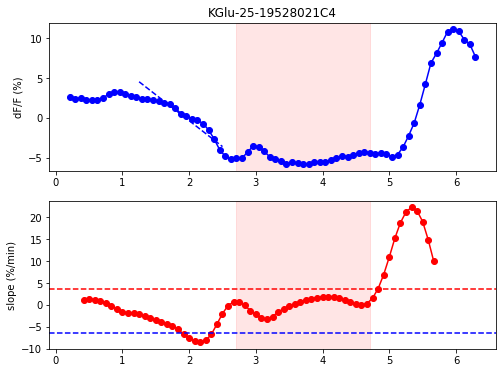

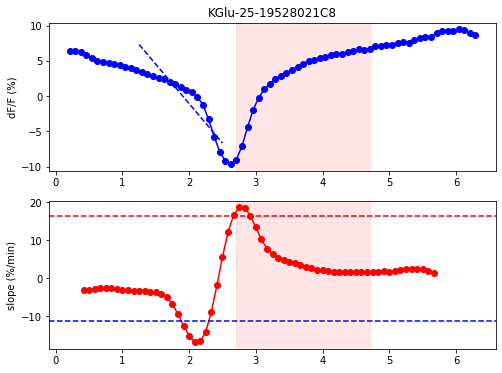

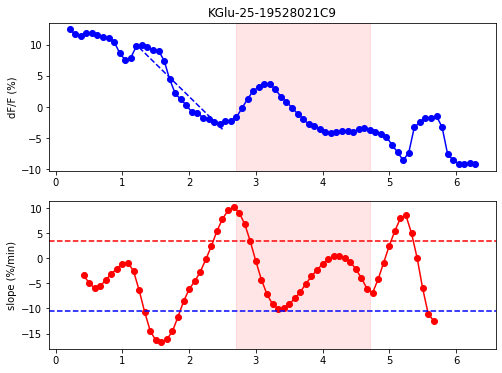

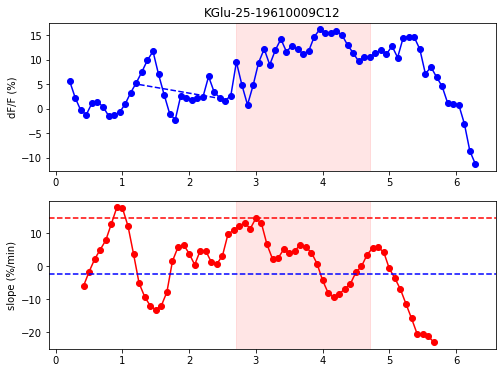

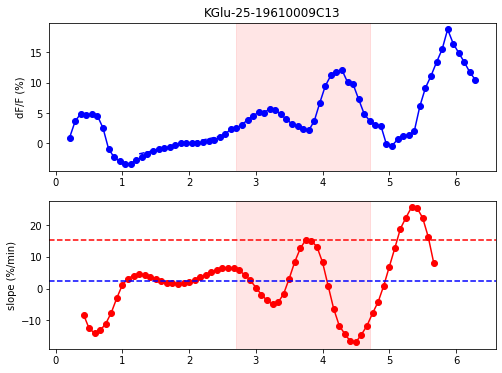

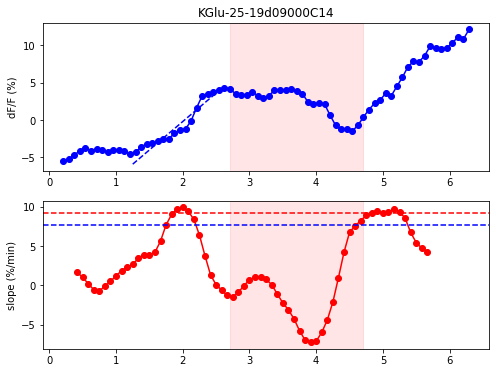

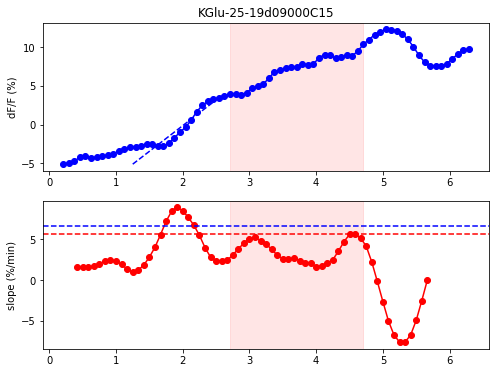

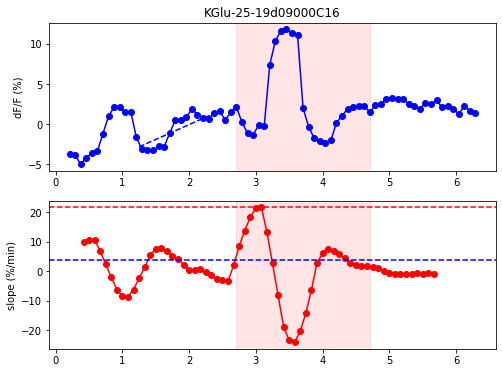

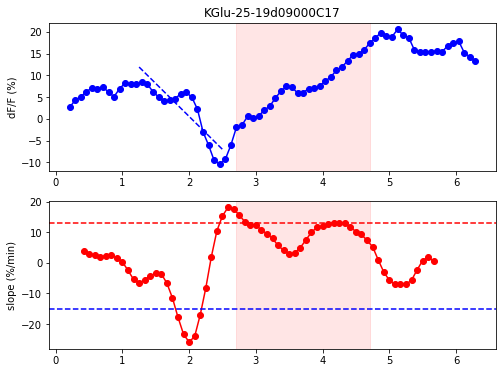

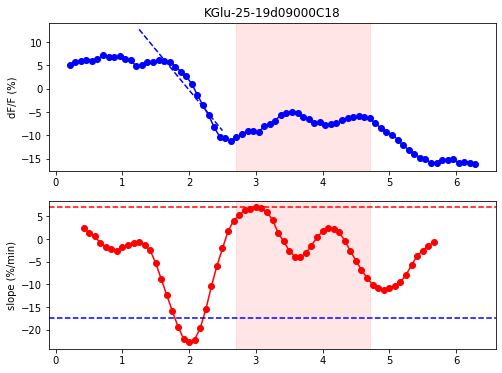

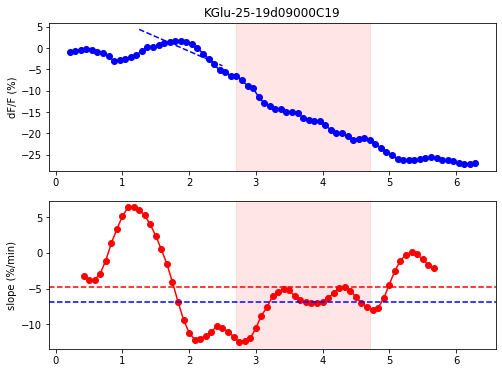

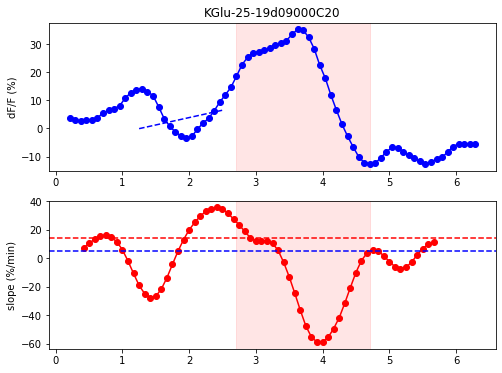

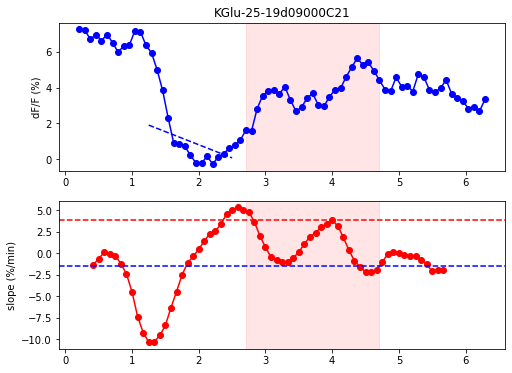

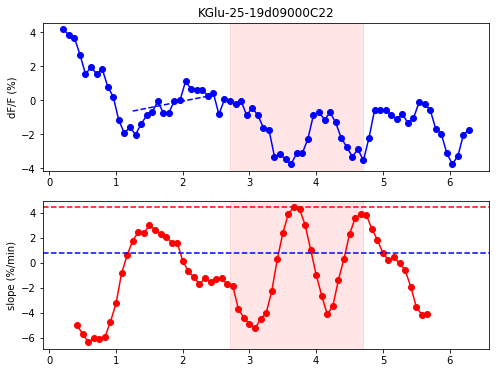

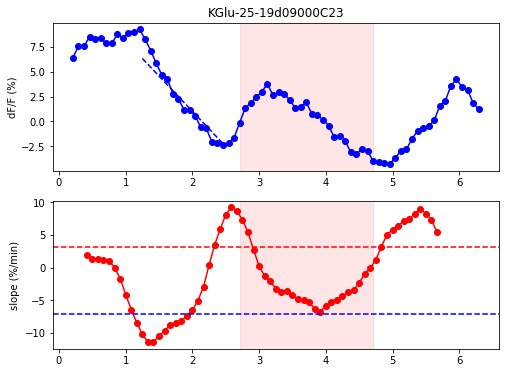

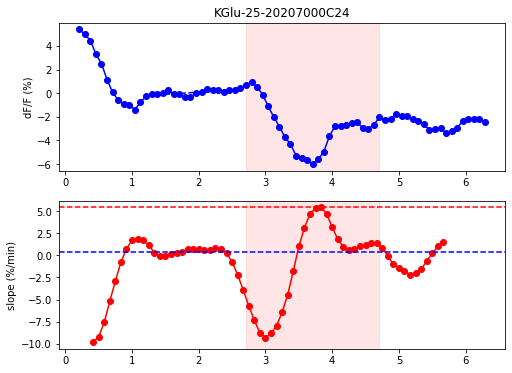

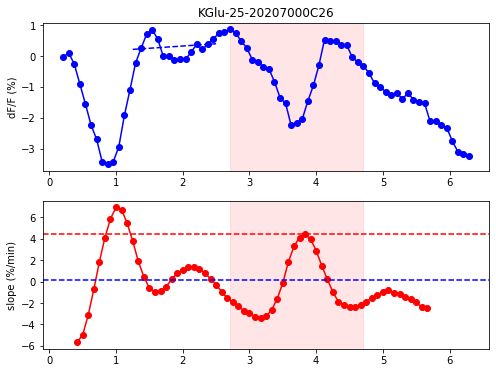

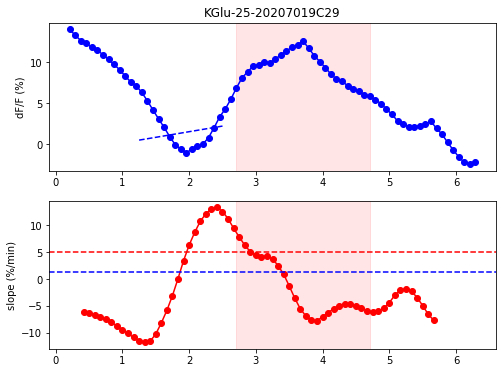

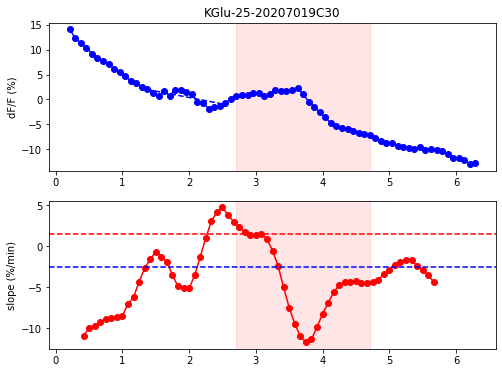

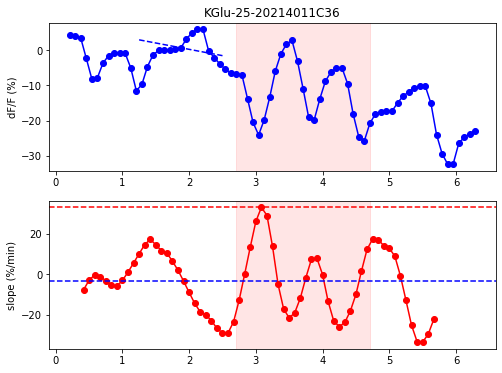

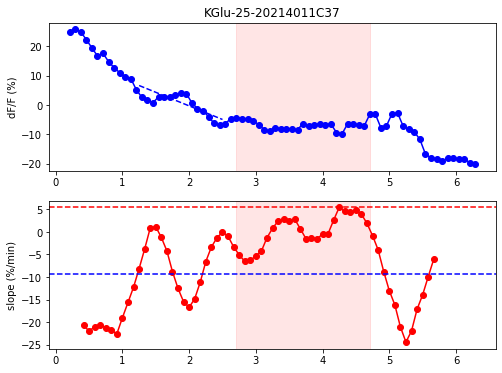

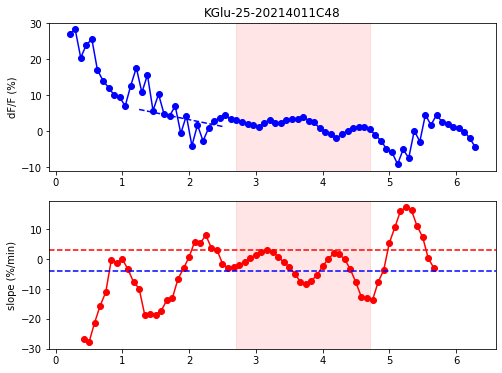

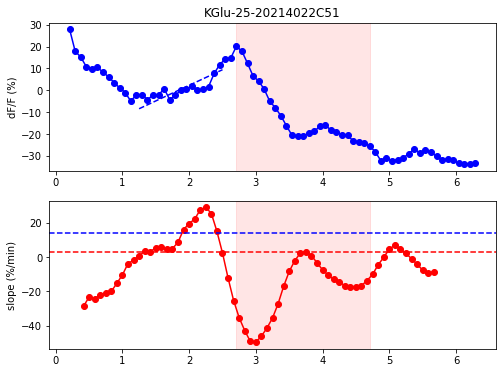

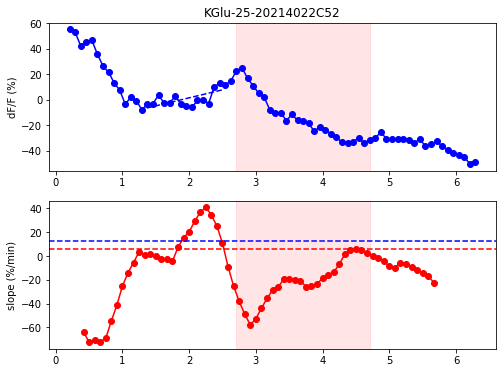

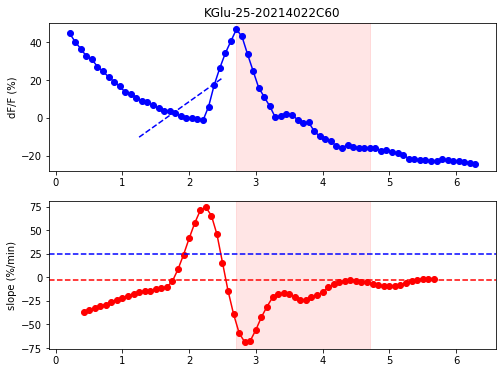

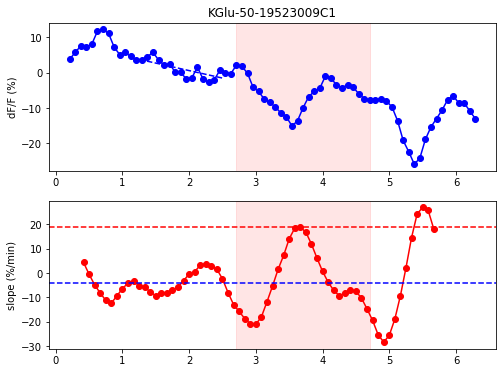

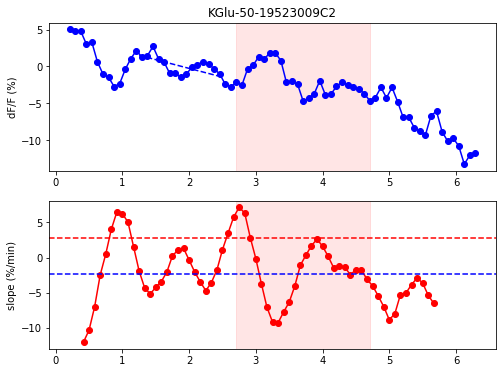

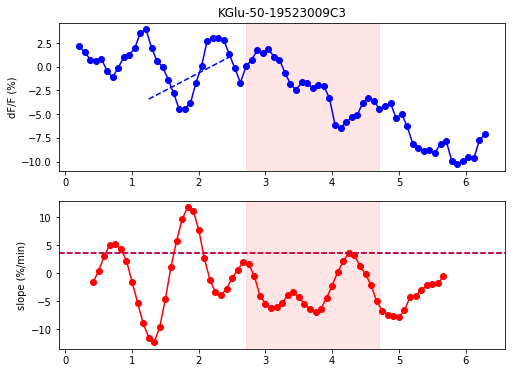

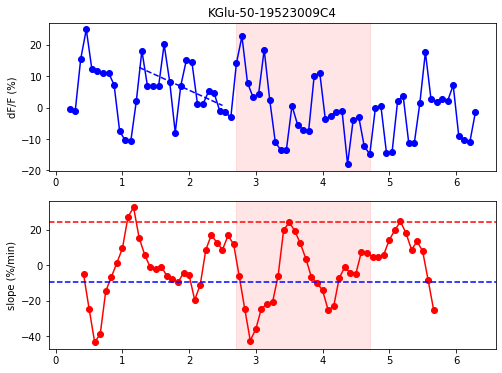

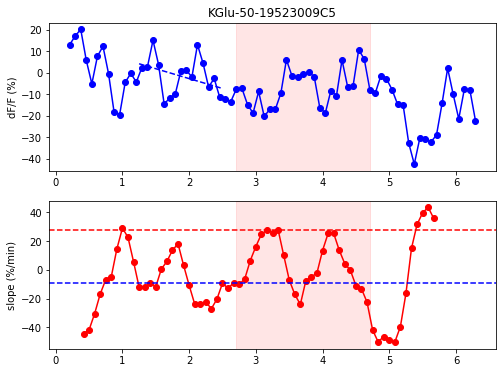

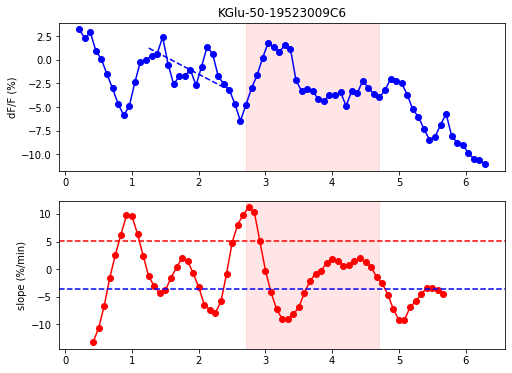

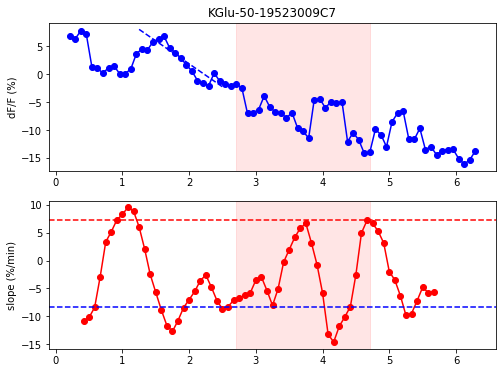

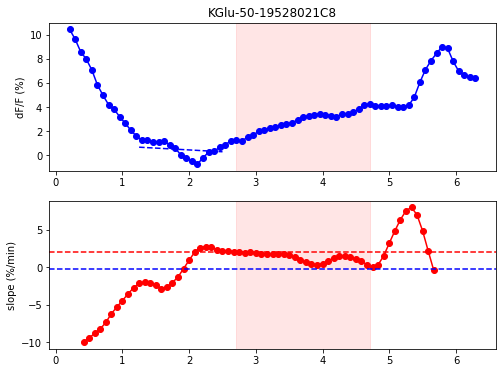

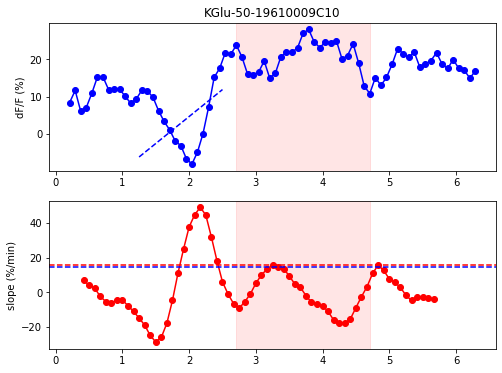

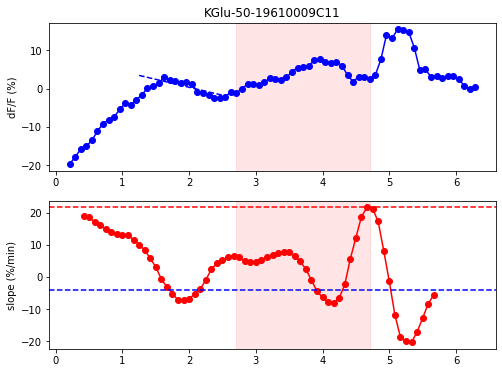

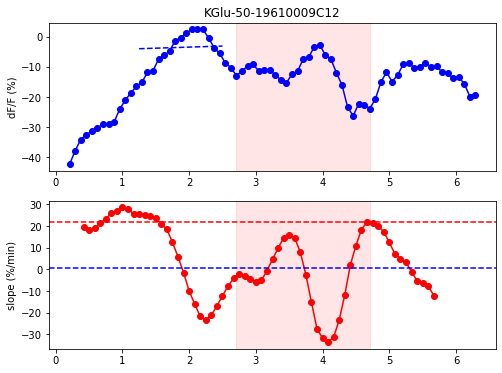

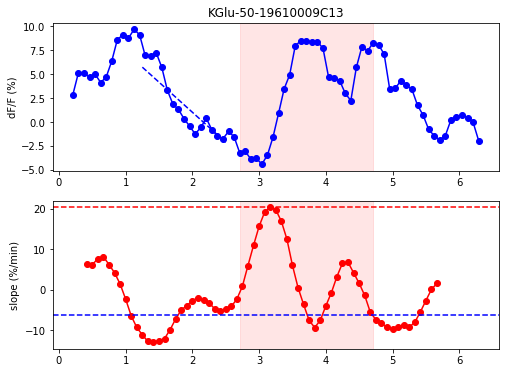

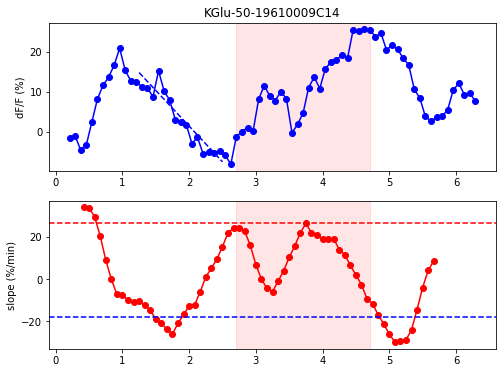

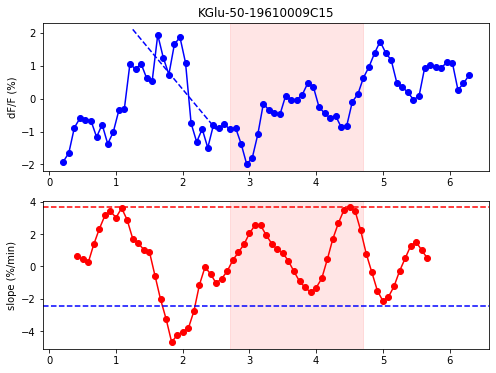

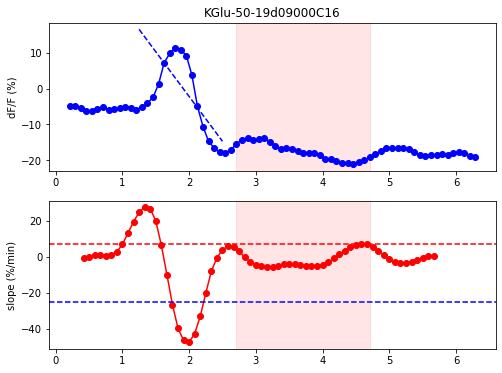

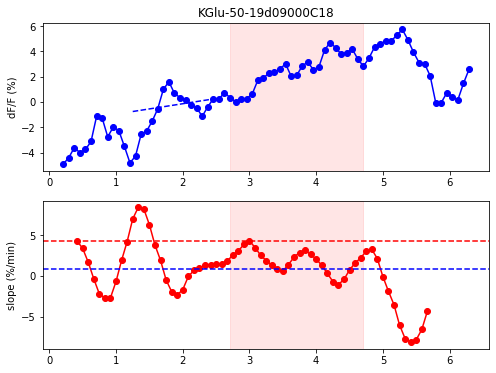

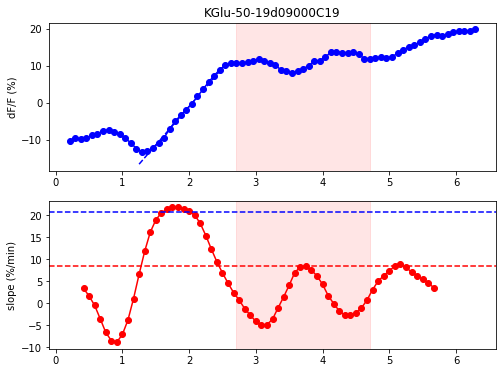

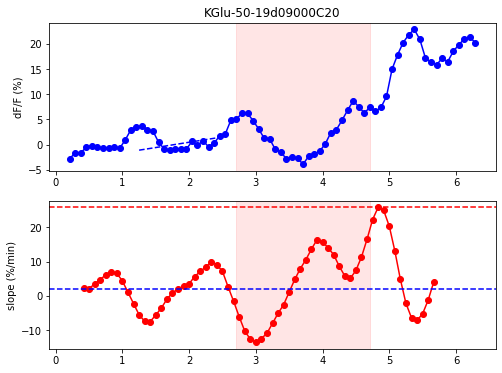

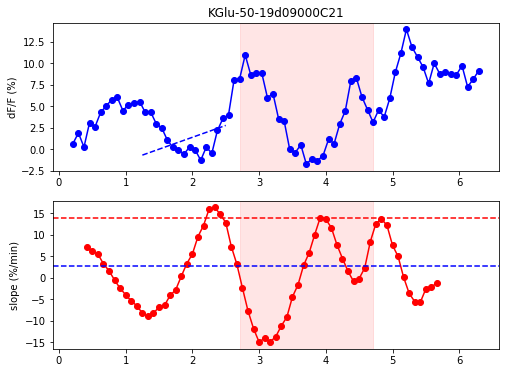

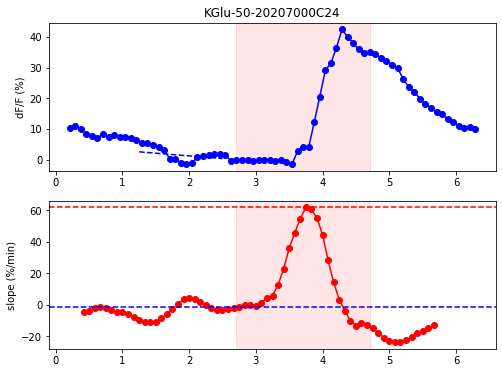

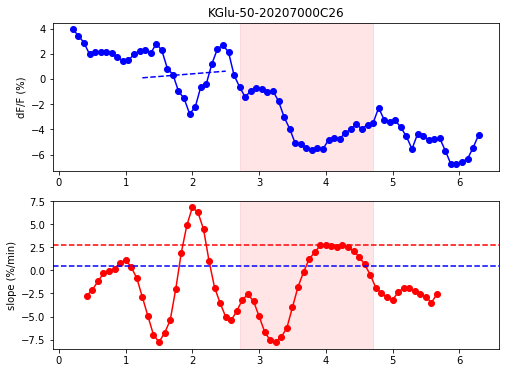

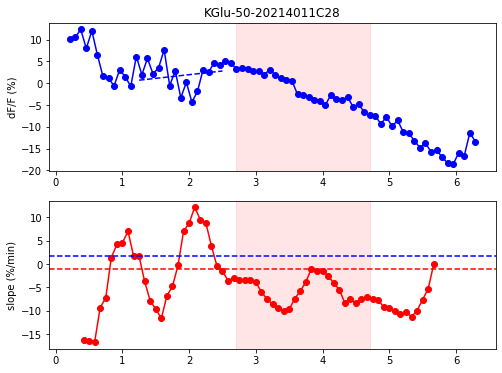

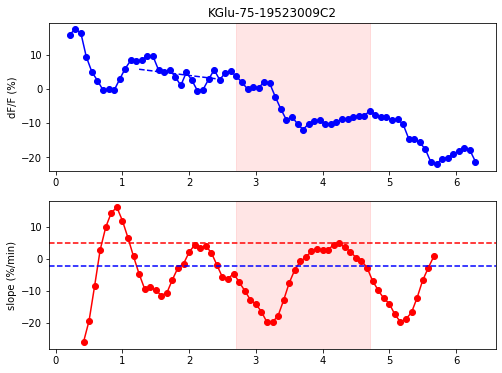

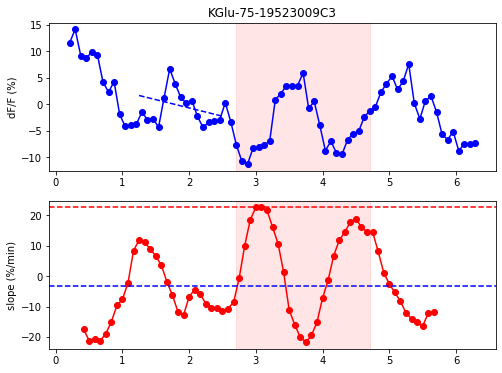

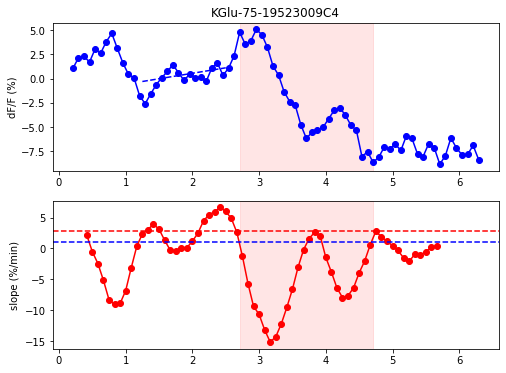

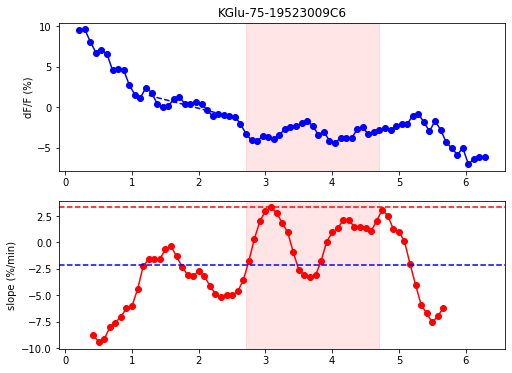

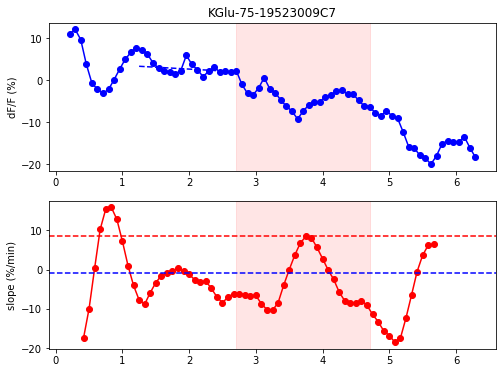

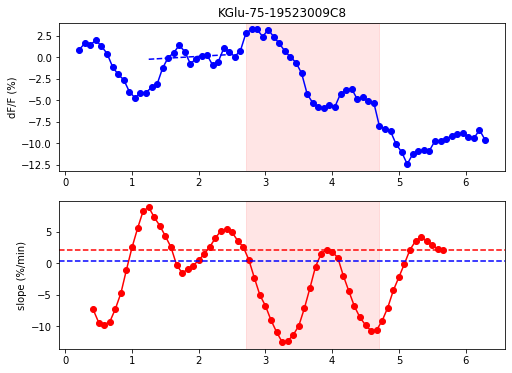

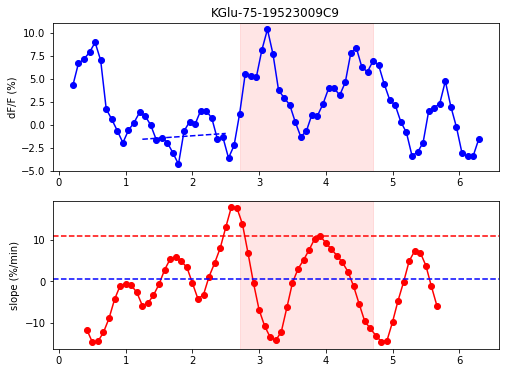

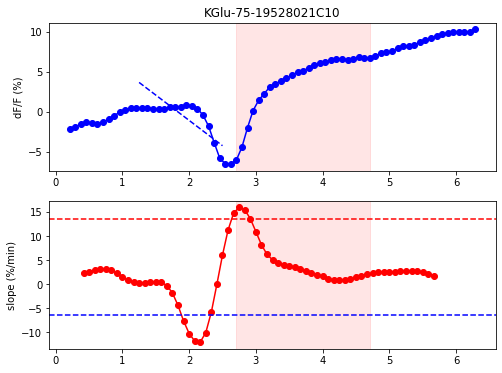

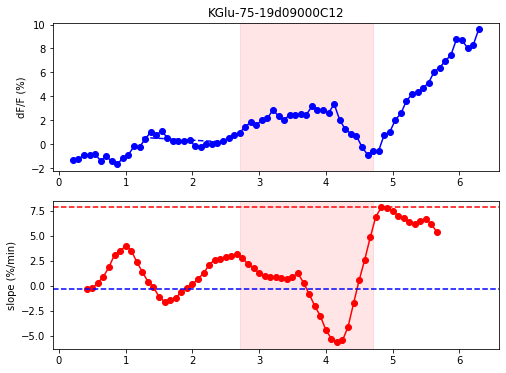

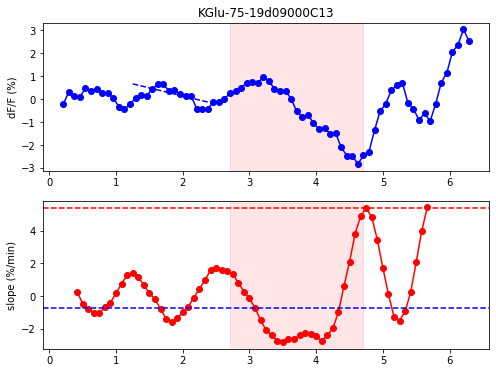

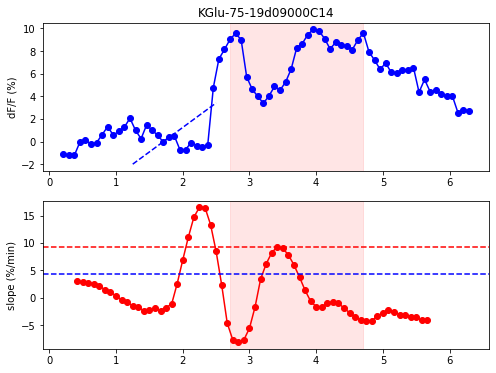

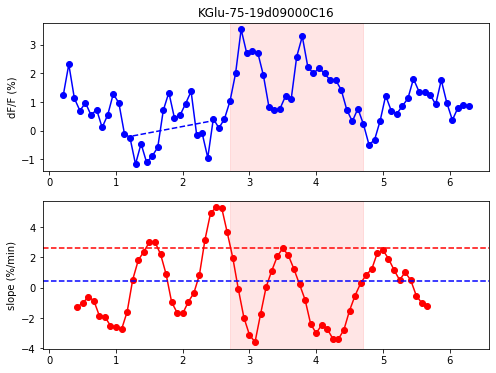

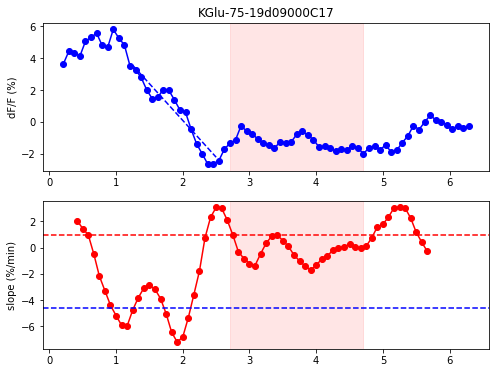

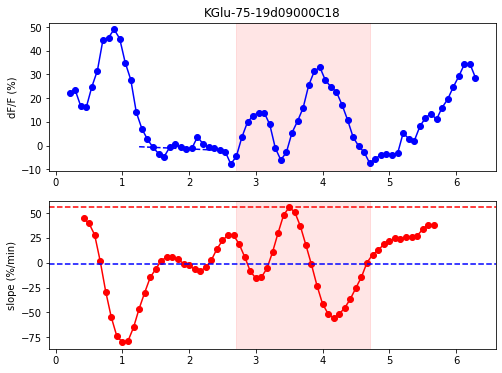

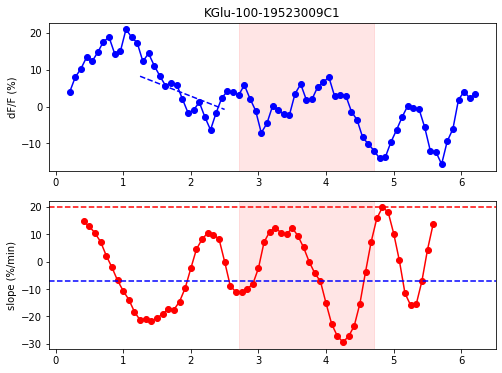

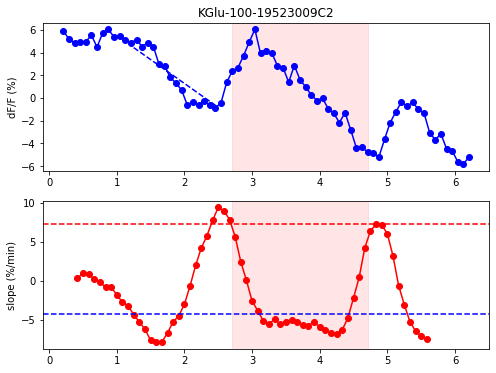

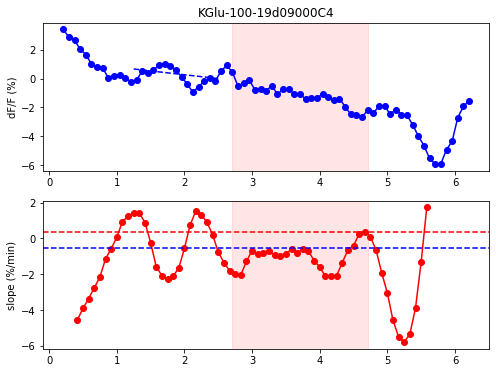

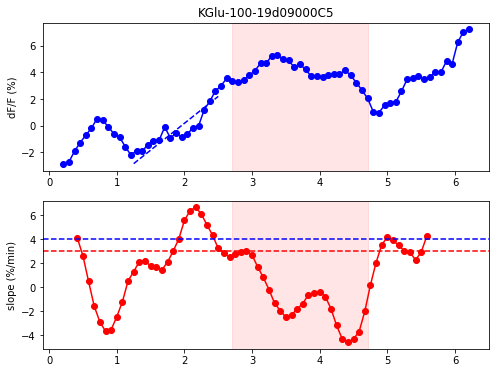

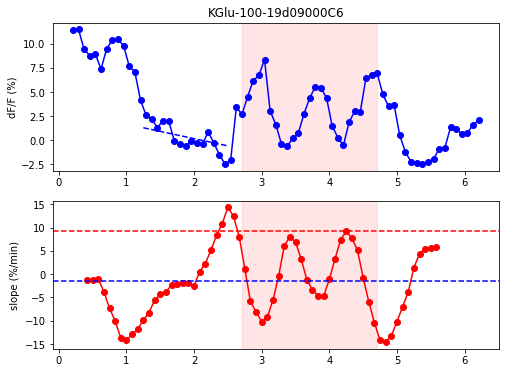

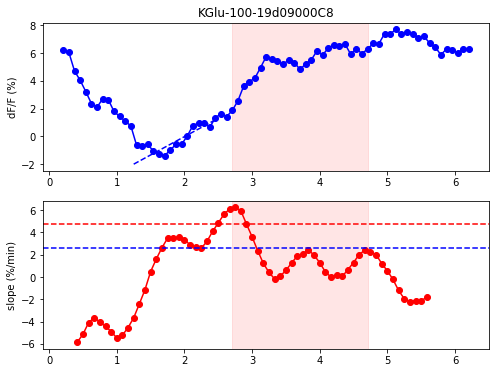

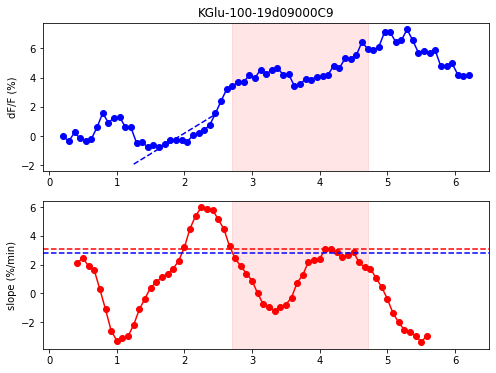

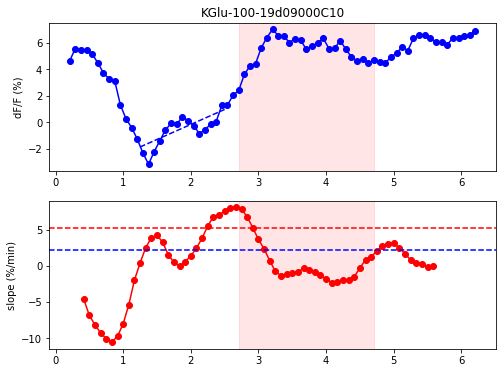

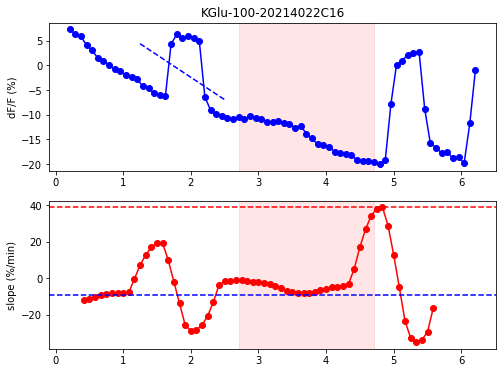

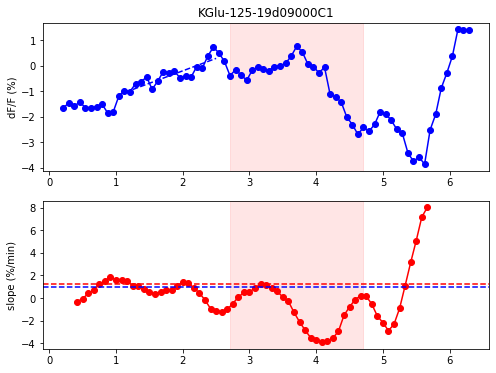

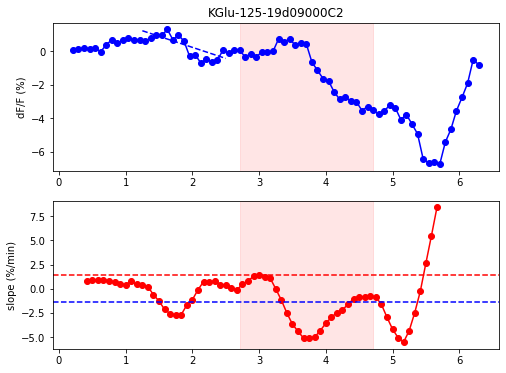

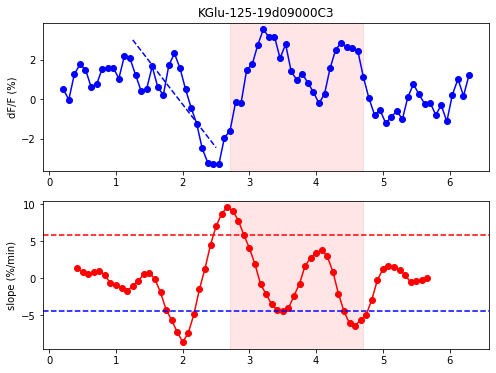

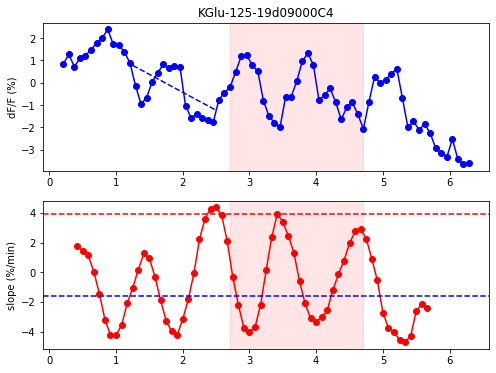

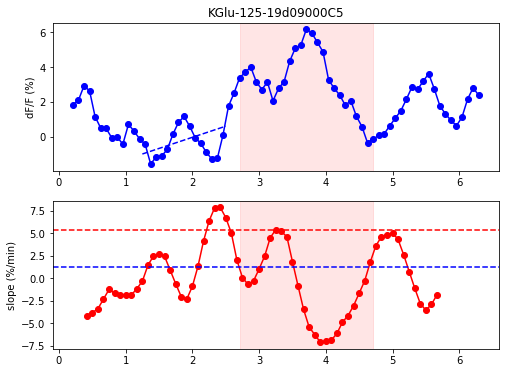

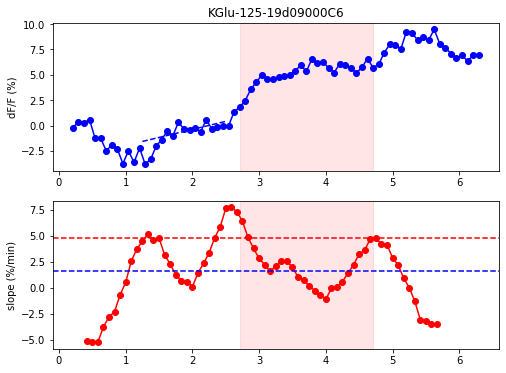

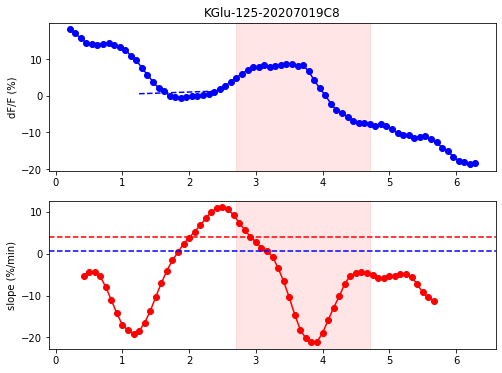

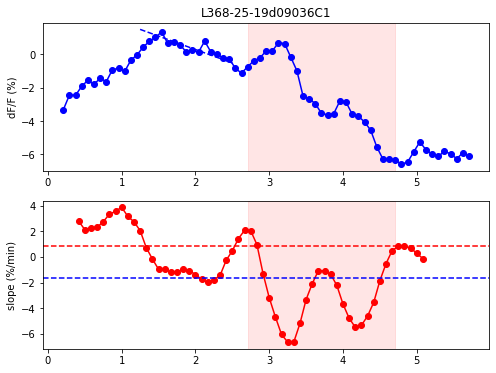

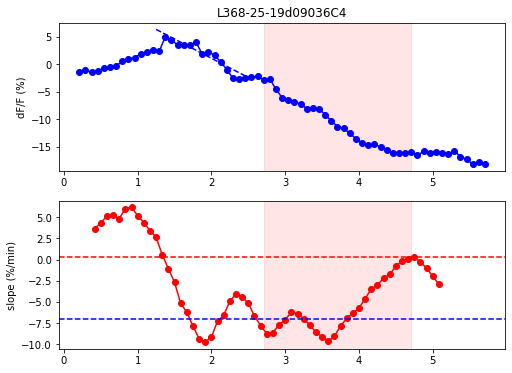

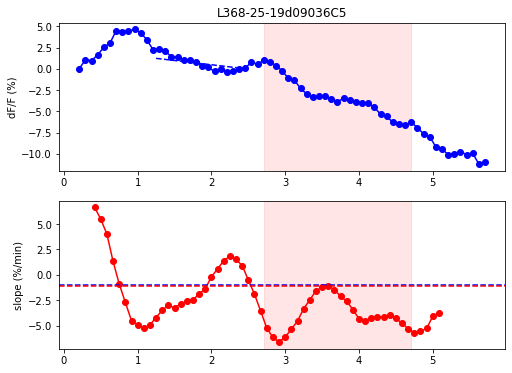

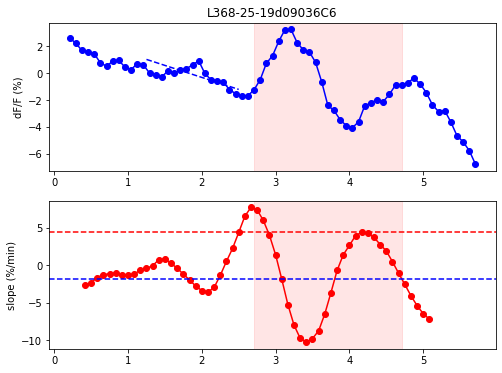

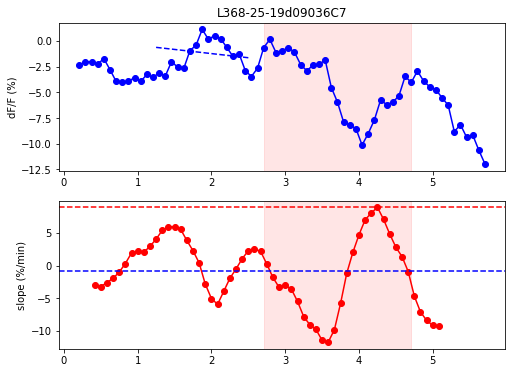

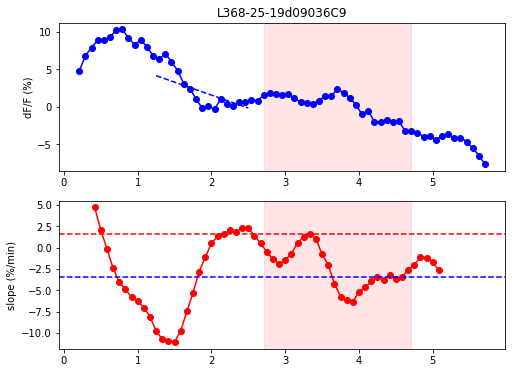

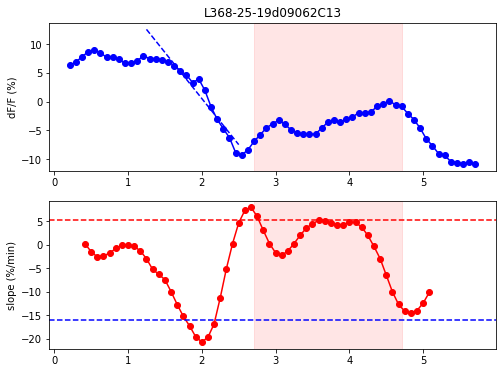

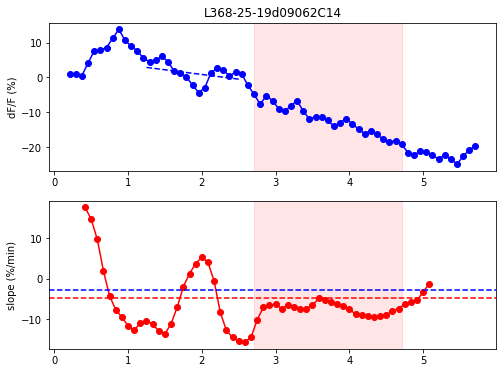

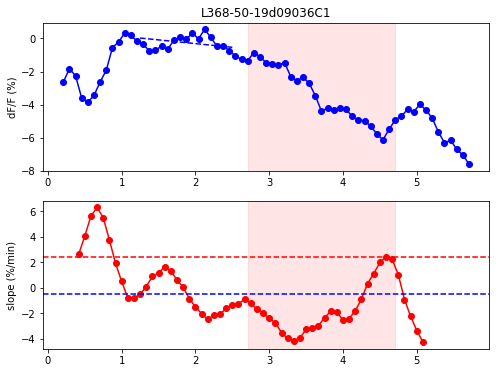

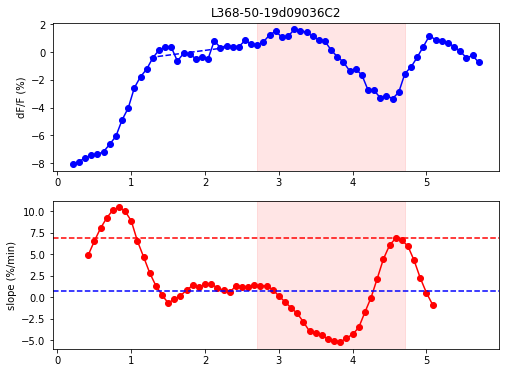

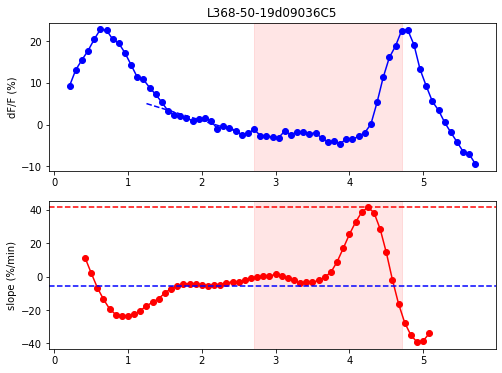

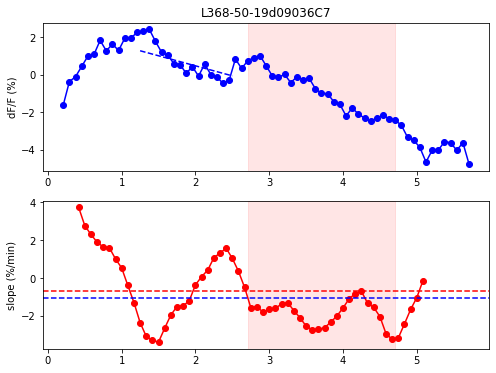

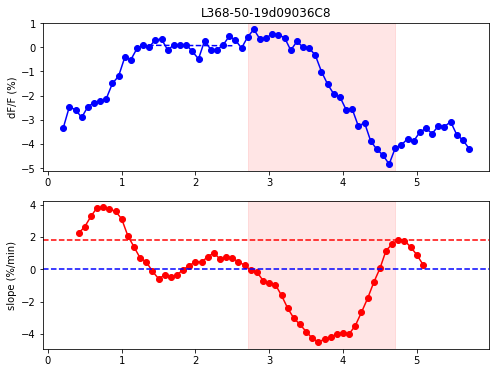

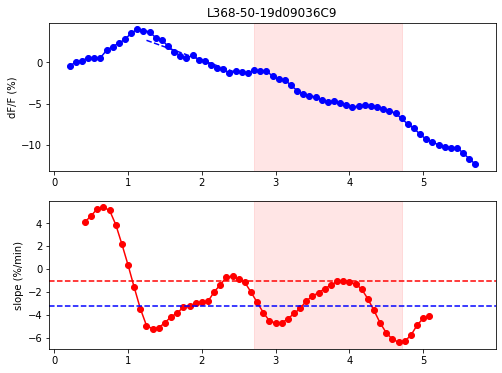

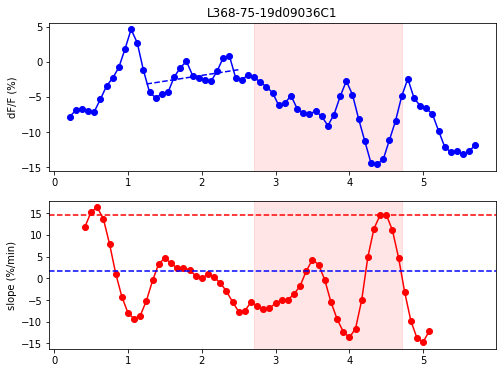

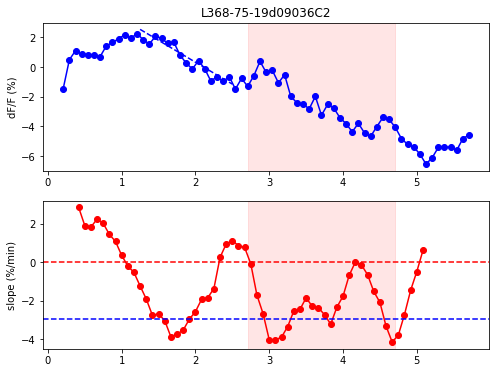

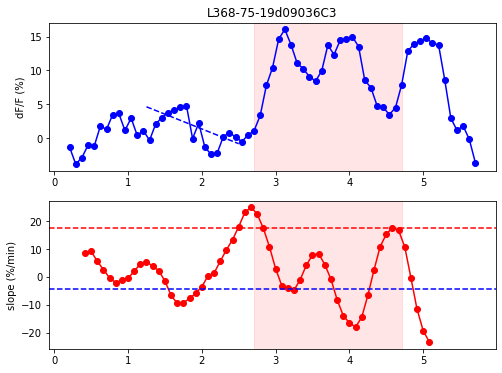

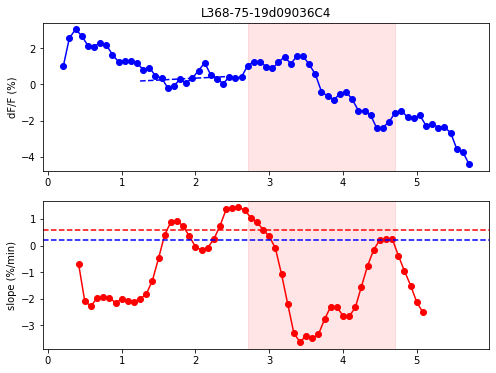

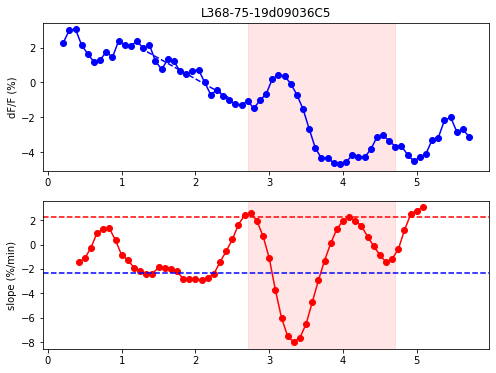

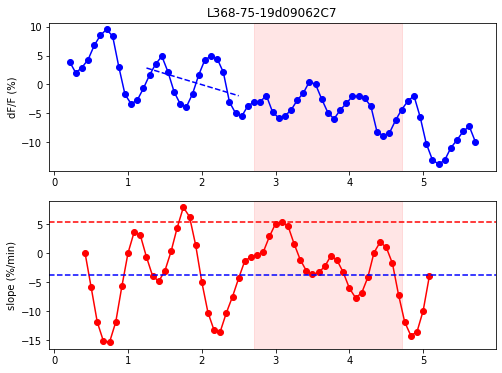

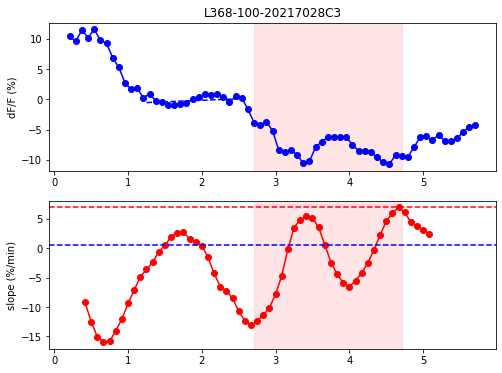

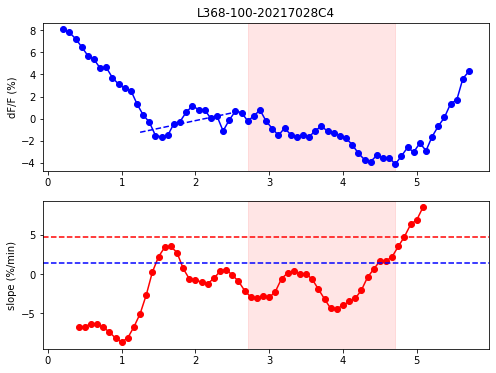

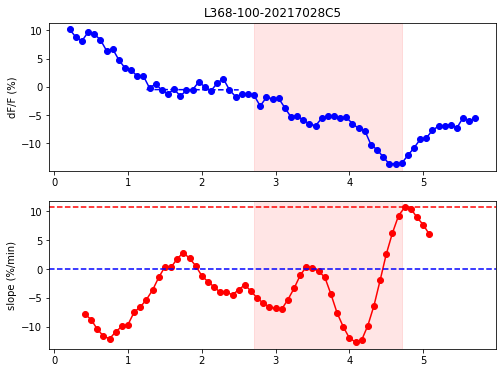

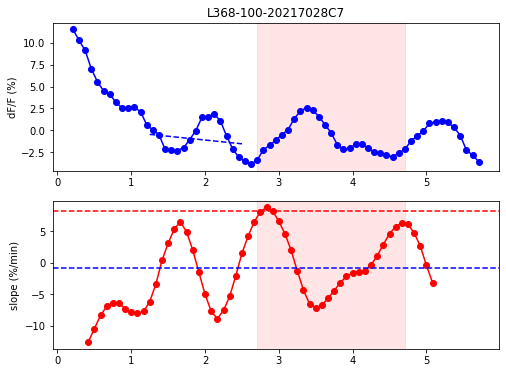

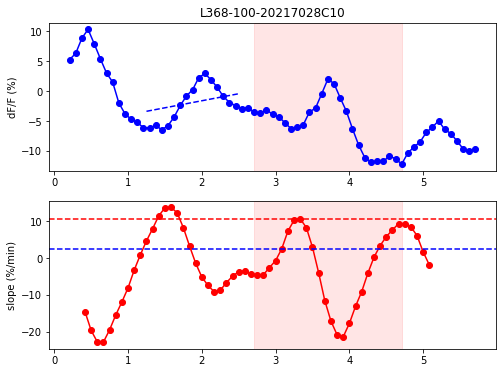

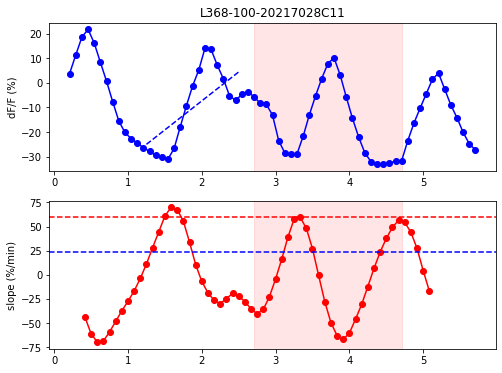

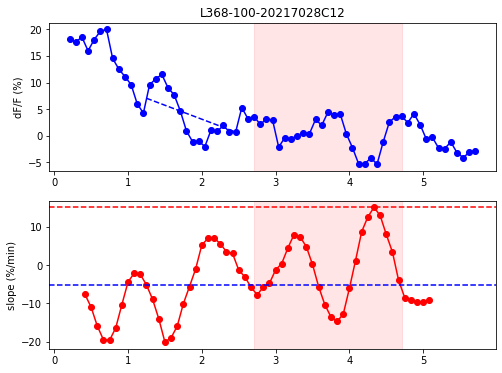

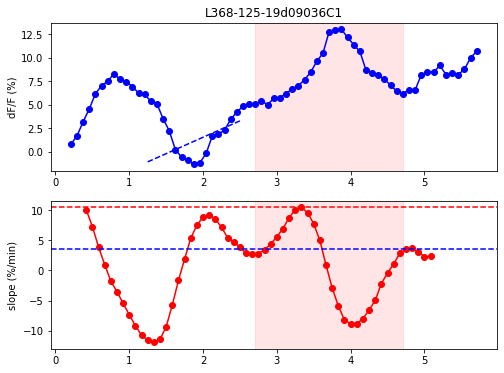

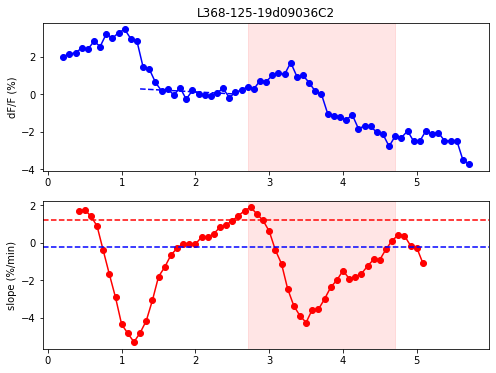

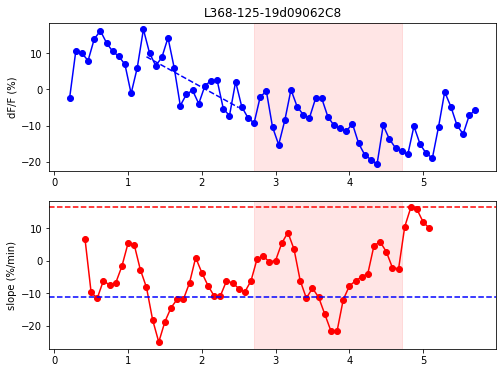

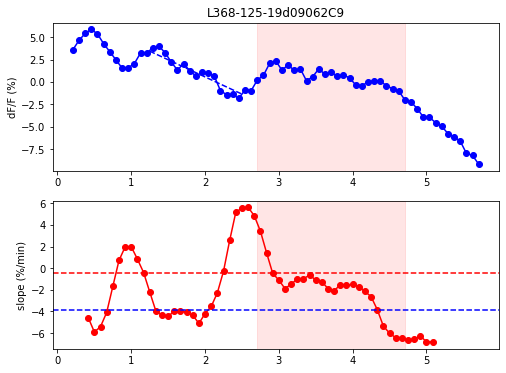

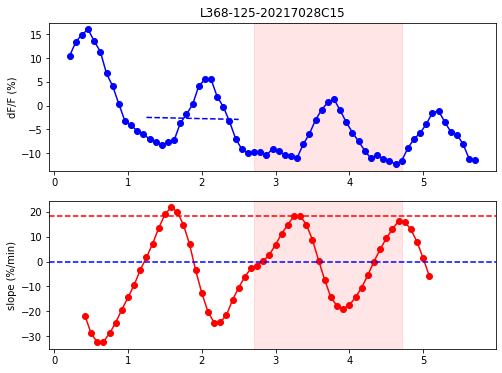

In [350]:
baselineStartIndex = 15  # index is right shifted for 2.5 indexes after smoothing
treatmentStartIndex = 30
treatmentDuration = 2

baselineSlopes =[]
stimulationSlopes =[]
slopeDifference = []
baselineTime = smoothTimes[baselineStartIndex:treatmentStartIndex]

#for index in range(len(analyzedCleaned["dF/F (%)"].values)):
for index in range(len(analyzedCleaned["dF/F (%)"].values)):
    dFoF = analyzedCleaned["dF/F (%)"].values[index]


    baselineSlope, baselineIntercept, r, p, stdErr = scipy.stats.linregress(baselineTime, dFoF[baselineStartIndex:treatmentStartIndex])
    baselineRegressionXs = np.linspace(time[baselineStartIndex], time[treatmentStartIndex])
    baselineRegressionYs = baselineRegressionXs * baselineSlope + baselineIntercept
    plt.figure(figsize=(8, 6))
    ax1 = plt.subplot(211)
    plt.plot(smoothTimes[:len(dFoF)], dFoF, 'o-', color='b', )
    plt.plot(baselineRegressionXs, baselineRegressionYs, color='b', ls='--')
    plt.title(analyzedCleaned["Group"].values[index]+"-"+str(analyzedCleaned["Distance"].values[index])+"-"+analyzedCleaned["MCN"].values[index]+analyzedCleaned["Sniffer"].values[index])
    plt.ylabel("dF/F (%)")
    
    
    plt.axvspan(smoothTimes[treatmentStartIndex], smoothTimes[treatmentStartIndex]+treatmentDuration, color='r', alpha=.1)
    baselineSlopes.append(baselineSlope)
    
    plt.subplot(212, sharex = ax1)
    plt.axvspan(smoothTimes[treatmentStartIndex], smoothTimes[treatmentStartIndex]+treatmentDuration, color='r', alpha=.1)
    plt.ylabel("slope (%/min)")
    
    segments = statsTools.getMovingWindowSegments(dFoF, regressionSize)
    segSlopes = slopeTools.getAllSegmentSlopes(segments, experimentPeriod)
    segSlopesList.append(segSlopes)
    segTimes = statsTools.smoothY(smoothTimes, filterSize)
    treatmentStartTime = segTimes[treatmentStartIndex]
    treatmentEndTime = treatmentStartTime + treatmentDuration
    treatmentSlopeMax = statsTools.rangeMax(segSlopes, segTimes, treatmentStartTime, treatmentEndTime)
    treatmentSlopeMaxIndex = segSlopes.index(treatmentSlopeMax)
    treatmentSlopeMaxTime = segTimes[treatmentSlopeMaxIndex]
    stimulationSlopes.append(treatmentSlopeMax)   
    plt.plot(segTimes[:len(segSlopes)], segSlopes, 'o-', color='r', )
    plt.axhline(baselineSlope, color='b', ls='--')
    plt.axhline(treatmentSlopeMax, color='r', ls='--')
    
    slopeDifference.append(treatmentSlopeMax-baselineSlope)

analyzedCleaned["slopeDifference (%)"] = slopeDifference



In [345]:
analyzedCleaned

Group Distance       MCN Sniffer  \
0    CsGlu       25  19514000      C1   
1    CsGlu       25  19514000      C2   
2    CsGlu       25  19514000      C3   
3    CsGlu       25  19514000      C4   
4    CsGlu       25  19514000      C5   
..     ...      ...       ...     ...   
427   L368      125  19d09036      C1   
428   L368      125  19d09036      C2   
434   L368      125  19d09062      C8   
435   L368      125  19d09062      C9   
441   L368      125  20217028     C15   

                                          Raw dF/F (%)  \
0    [26.876577163943114, 24.864685904510754, 17.29...   
1    [-1.6574346372227533, -1.1807155509507214, 8.0...   
2    [28.56409879575307, 28.56606364761605, 12.6514...   
3    [27.972329497133295, 23.927243542925748, 26.27...   
4    [23.747368607671493, 8.408896655945105, 22.260...   
..                                                 ...   
427  [-0.4086253989051729, -1.5728694273641552, -0....   
428  [0.17781036529276772, 4.047615664363747, 0.864...   
434  [-21.72967814699643, 17.263367591447377, 13.91...   
435  [-0.020436071814665634, 1.7243421436191606, 0....   
441  [-0.5552749665760618, 10.83503053803611, 4.757...   

                                              dF/F (%)  slopeDifference (%)  
0    [21.84072307926667, 19.003907158001294, 16.241...            11.784731  
1    [7.763973194601914, 9.775688043374481, 11.1001...             4.414812  
2    [9.291335093843292, 10.769249062288777, 13.264...            12.444155  
3    [28.11335145335973, 28.311119053030833, 28.082...             5.630190  
4    [19.80381459331928, 18.16510188118031, 18.1830...             5.667450  
..                                                 ...                  ...  
427  [0.7621180937095895, 1.675357936989765, 3.1968...             6.969439  
428  [1.997204168044209, 2.153043222349471, 2.18559...             1.386257  
434  [-2.407289679887425, 10.512901252428042, 9.999...            27.730756  
435  [3.5902843764287824, 4.63325365515546, 5.41332...             3.352028  
441  [10.466257991487444, 13.406909232091417, 14.97...            18.643010  

[209 rows x 7 columns]

# Plot response rate by groups

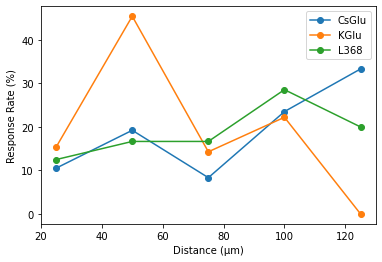

In [349]:
def identifyResponders(df, groupName, distance, slopeDifferenceThreshold):
    """
    Given a dataframe, group, and distance, return just the cells that change
    more than the given threshold.
    """
    matching = df.loc[analyzedCleaned['Group'] == group]
    matching = matching.loc[analyzedCleaned['Distance'] == distance]
    totalCellCount = len(matching)
    matching = matching.loc[analyzedCleaned['slopeDifference (%)'] > slopeDifferenceThreshold]
    responderCount = len(matching)
    return matching, totalCellCount, responderCount
    

groups = ["CsGlu", "KGlu", "L368"]
distances = [25, 50, 75, 100, 125]
threshold = 20

for group in groups:
    responseByDistance = []
    for distance in distances:
        matching, totalCellCount, responderCount = identifyResponders(analyzedCleaned, group, distance, threshold)
        #sniffers = sorted(list(set(matching['MCN'])))
        responseRate = responderCount*100/totalCellCount
        responseByDistance.append(responseRate)
    
    plt.plot(distances, responseByDistance, 'o-', label=group)

plt.legend()
plt.ylabel("Response Rate (%)")
plt.xlabel("Distance (µm)")
plt.show()


# Group sniffers by MCNs